In [1]:
import importlib

import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import json
import sys
import os

sys.path.insert(1, '/home/maciek/Documents/Magisterka/kubernetes-anomaly-detector')
print(sys.path)


import kad.visualization.visualization as visualization
import kad.kad_utils.kad_utils as kad_utils
import kad.models_evaluation.models_evaluator as models_evaluator
import kad.model_selector.model_selector as model_selector
from kad.model import i_model, autoencoder_model, hmm_model, lstm_model
from kad.model import sarima_model
from sklearn.model_selection import train_test_split

models_evaluator = importlib.reload(models_evaluator)

kad_utils.customize_matplotlib()

ModuleNotFoundError: No module named 'kad'

In [ ]:
SARIMA_KEY: str = "SARIMA"
AUTOENCODER_KEY: str = "autoencoder"
HMM_KEY: str = "HMM"
LSTM_KEY: str = "LSTM"

ACC_KEY: str = "accuracy"
PREC_KEY: str = "precision"
RECALL_KEY: str = "recall"
AUROC_KEY: str = "auroc"
CUSTOM_KEY: str = "custom"

In [ ]:

def downsampling_func(x: pd.DataFrame):
    """
    Values column is replaced with a mean, and labels are replaced by True if any of the labels
    in the original df was True
    :param x: part of dataframe to squash to one row
    :return: squashed pandas Series
    """
    values = x["value"].mean()

    labels = (x[kad_utils.GROUND_TRUTH_COLUMN]).any()

    return pd.Series([values, labels], index=["value", kad_utils.GROUND_TRUTH_COLUMN])

In [ ]:
def perform_classical_evaluation(evaluation_df: pd.DataFrame) -> dict:
    visualization.visualize(evaluation_df, metric_name="value")

    evaluator = models_evaluator.ModelsEvaluator(df=evaluation_df)

    print("Accuracy: ", evaluator.get_accuracy())
    print("Avg precision: ", evaluator.get_average_precision())
    print("Recall: ", evaluator.get_recall_score())
    print("AU ROC: ", evaluator.get_auroc())

    return {ACC_KEY: evaluator.get_accuracy(),
            PREC_KEY: evaluator.get_average_precision(),
            RECALL_KEY: evaluator.get_recall_score(),
            AUROC_KEY: evaluator.get_auroc()}


In [ ]:
def perform_customized_evaluation(evaluation_df: pd.DataFrame) -> dict:
    visualization.visualize(evaluation_df, metric_name="value")

    evaluator = models_evaluator.ModelsEvaluator(df=evaluation_df)

    print("Customized score: ", evaluator.get_customized_score())

    return {CUSTOM_KEY: evaluator.get_customized_score()}


In [ ]:
def evaluate_sarima(p_preprocessed_df: pd.DataFrame) -> pd.DataFrame:
    values_df = p_preprocessed_df[["value"]]
    tsa = model_selector.ModelSelector(values_df)
    dominant_freq = tsa.calculate_dominant_frequency()

    model: i_model.IModel = sarima_model.SarimaModel(order=(0, 0, 0), seasonal_order=(1, 0, 1, dominant_freq))

    train_df, test_df = train_test_split(values_df, shuffle=False, train_size=0.15)
    model.train(train_df)

    results_df = pd.DataFrame()
    samples_to_predict = 18
    for i in range(0, len(test_df), samples_to_predict):
        results_df = model.test(test_df.iloc[i:i + samples_to_predict])

    results_df[kad_utils.GROUND_TRUTH_COLUMN] = p_preprocessed_df[kad_utils.GROUND_TRUTH_COLUMN]
    return results_df.loc[test_df.index & results_df.index]

In [ ]:
def evaluate_autoencoder(p_preprocessed_df: pd.DataFrame) -> pd.DataFrame:
    model: i_model.IModel = autoencoder_model.AutoEncoderModel(time_steps=12)

    values_df = p_preprocessed_df[["value"]]
    train_df, test_df = train_test_split(values_df, shuffle=False, train_size=0.15)
    model.train(train_df)

    results_df = pd.DataFrame()
    samples_to_predict = 60
    for i in range(0, len(test_df), samples_to_predict):
        if len(test_df.iloc[i:i + samples_to_predict]) < samples_to_predict:
            break
        results_df = model.test(test_df.iloc[i:i + samples_to_predict])

    results_df[kad_utils.GROUND_TRUTH_COLUMN] = p_preprocessed_df[kad_utils.GROUND_TRUTH_COLUMN]
    return results_df.loc[test_df.index & results_df.index]

In [ ]:
def evaluate_hmm(p_preprocessed_df: pd.DataFrame) -> pd.DataFrame:
    model: i_model.IModel = hmm_model.HmmModel()

    values_df = p_preprocessed_df[["value"]]
    train_df, test_df = train_test_split(values_df, shuffle=False, train_size=0.15)
    model.train(train_df)

    results_df = pd.DataFrame()
    samples_to_predict = 5
    for i in range(0, len(test_df), samples_to_predict):
        if len(test_df.iloc[i:i + samples_to_predict]) < samples_to_predict:
            break
        results_df = model.test(test_df.iloc[i:i + samples_to_predict])

    results_df[kad_utils.GROUND_TRUTH_COLUMN] = p_preprocessed_df[kad_utils.GROUND_TRUTH_COLUMN]
    return results_df.loc[test_df.index & results_df.index]

In [ ]:
def evaluate_lstm(p_preprocessed_df: pd.DataFrame) -> pd.DataFrame:
    model: i_model.IModel = lstm_model.LstmModel(time_steps=12)

    values_df = p_preprocessed_df[["value"]]
    train_df, test_df = train_test_split(values_df, shuffle=False, train_size=0.15)
    model.train(train_df)

    results_df = pd.DataFrame()
    samples_to_predict = 25
    for i in range(0, len(test_df), samples_to_predict):
        if len(test_df.iloc[i:i + samples_to_predict]) < samples_to_predict:
            break
        results_df = model.test(test_df.iloc[i:i + samples_to_predict])

    results_df[kad_utils.GROUND_TRUTH_COLUMN] = p_preprocessed_df[kad_utils.GROUND_TRUTH_COLUMN]
    return results_df.loc[test_df.index & results_df.index]

31/31 [==============================]16/31 [==============>...............] - ETA: 0s - loss: 0.0039 - ETA: 1s - loss: 8.7297e-04 - ETA: 0s - loss: 0.0041 - ETA: 0s - loss: 0.0044 - ETA: 0s - loss: 0.0039 - ETA: 0s - loss: 0.0041 - ETA: 0s - loss: 0.003924/31 [======================>.......]11/31 [=========>....................]20/31 

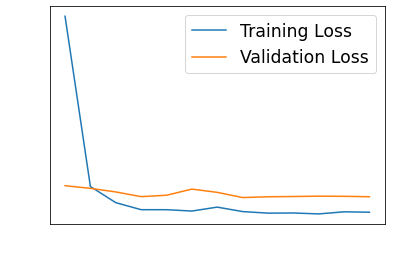

10/31 [========>.....................]30/31 [============================>.] - ETA: 0s - loss: 0.0036 - ETA: 0s - loss: 0.003031/31 [==============================] - 2s 55ms/step - loss: 0.0010 - val_loss: 0.0020
Epoch 14/50
31/31 [==============================] - ETA: 1s - loss: 0.0016 - ETA: 0s - loss: 0.0037 - ETA: 0s - loss: 0.0014 - ETA: 0s - loss: 0.0038 - ETA: 1s - loss: 0.0014 - 2s 60ms/step - loss: 0.0030 - val_loss: 0.0070
Epoch 13/50
31/31 [==============================]

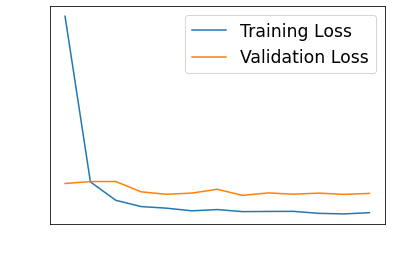

31/31 [==============================]13/31 [===========>..................] - ETA: 0s - loss: 9.3142e-0424/31 [======================>.......] - ETA: 0s - loss: 0.003614/31 [============>.................]25/31 [=======================>......] - ETA: 0s - loss: 0.0037 - ETA: 0s - loss: 8.9947e-04 - ETA: 0s - loss: 0.0037 - ETA: 0s - loss: 0.0037 - ETA: 0s - loss: 8.8028e-04 - ETA: 0s - loss: 0.0037 - ETA: 0s - loss: 8.6579e-04

<ipython-input-7-a71f714408fd>:16: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  return results_df.loc[test_df.index & results_df.index]


31/31 [==============================] - ETA: 0s - loss: 0.0026 - 2s 49ms/step - loss: 9.2177e-04 - val_loss: 0.0015
Epoch 20/50
31/31 [==============================] - ETA: 0s - loss: 4.3282e-04 - ETA: 0s - loss: 0.0027 - ETA: 0s - loss: 0.0028 - ETA: 1s - loss: 5.3469e-04 - ETA: 0s - loss: 0.0028 - ETA: 1s - loss: 5.4082e-04 - ETA: 0s - loss: 0.0029 - ETA: 0s - loss: 6.0641e-04 - ETA: 0

<ipython-input-7-a71f714408fd>:16: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  return results_df.loc[test_df.index & results_df.index]


31/31 [==============================] - ETA: 0s - loss: 4.7788e-04 - 1s 39ms/step - loss: 0.0027 - val_loss: 0.0048
Epoch 21/50
31/31 [==============================] - ETA: 0s - loss: 4.8796e-04 - ETA: 0s - loss: 0.0016 - ETA: 0s - loss: 4.9431e-04 - ETA: 0s - loss: 0.0025 - ETA: 0s - loss: 5.0214e-04 - ETA: 0s - loss: 0.0028 - ETA: 0s - loss: 5.1305e-04 - ETA: 0s - loss: 0.0028 - ETA: 0s - loss: 5.2152e-04

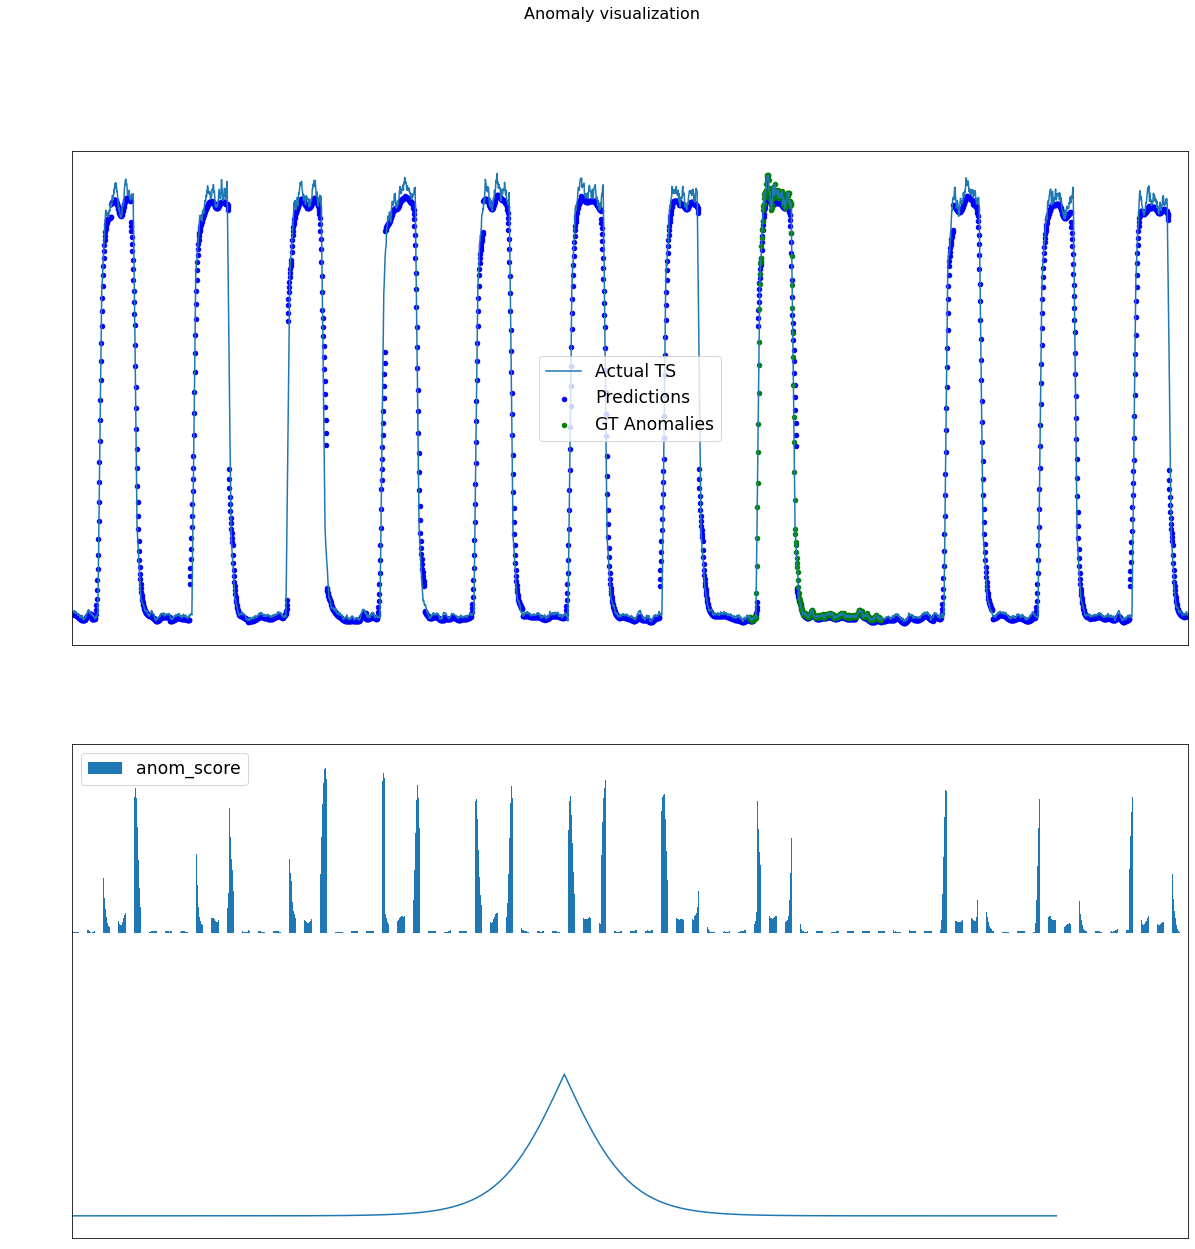

Customized score:  0.3333333333333333
0.031 [=========>....................] - ETA: 0s - loss: 4.7548e-04 7/31 [=====>........................]
13/31 [===========>..................] - ETA: 0s - loss: 4.5777e-04 - ETA: 0s - loss: 0.0012 - ETA: 0s - loss: 4.4186e-04 - ETA: 0s - loss: 0.0012 - ETA: 0s - loss: 4.2719e-04 - ETA: 0s - loss: 0.0012

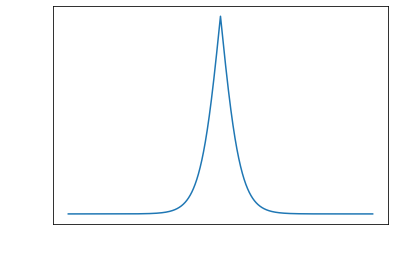

 - 1s 44ms/step - loss: 3.7572e-04 - val_loss: 2.5853e-0414/31 [============>.................]19/31 [=================>............] - ETA: 0s - loss: 4.1538e-04 - ETA: 0s - loss: 0.0012 - ETA: 0s - loss: 0.0012 - ETA: 0s - loss: 4.0628e-04 - ETA: 0s - loss: 0.0013 - ETA: 0s - loss: 3.9783e-04 - ETA: 0s - loss: 0.0013 - ETA: 0s - loss: 3.9069e-04 - ETA: 0s - loss: 0.0013 - ETA: 0s - loss: 3.8779e-04

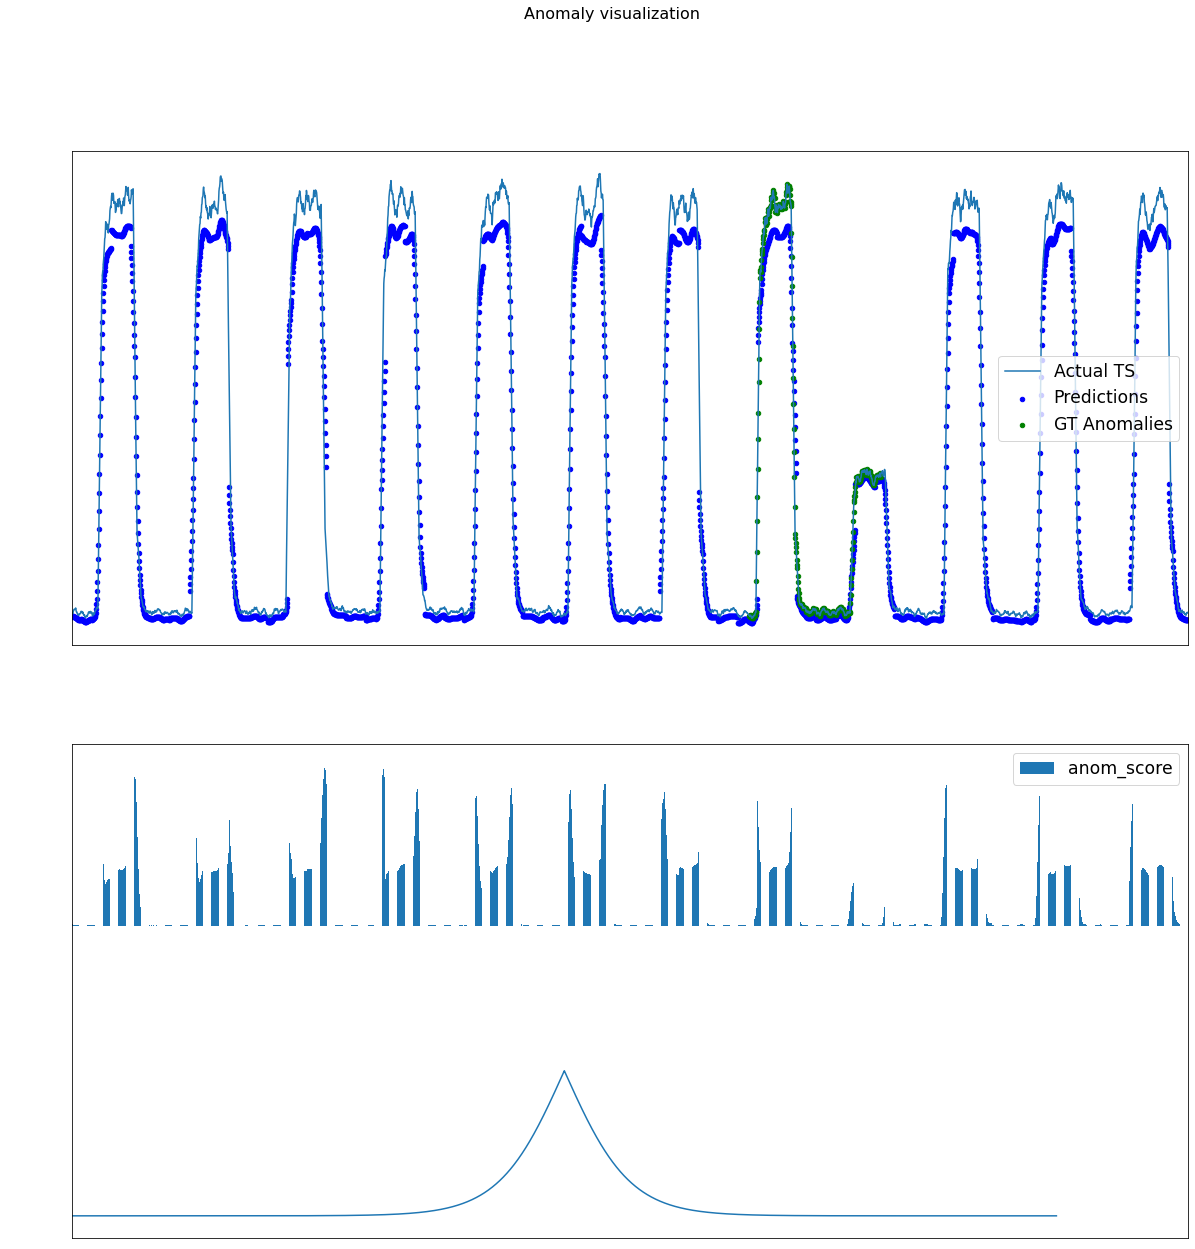

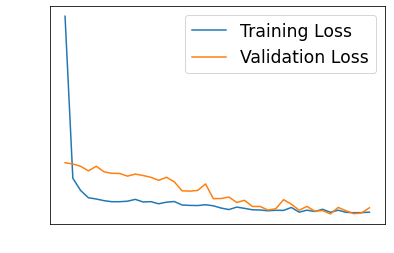

0.3333333333333333Customized score:  13/31 [===========>..................]
 - ETA: 0s - loss: 4.2246e-040.0
15/31 [=============>................] - ETA: 0s - loss: 4.1728e-04

<ipython-input-8-2e85185fa41f>:16: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  return results_df.loc[test_df.index & results_df.index]


18/31 [================>.............] - ETA: 0s - loss: 4.1385e-04 - ETA: 0s - loss: 4.1104e-04 - ETA: 0s - loss: 4.0830e-04

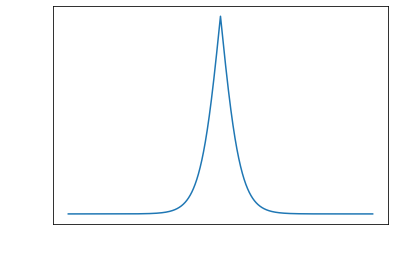

31/31 [==============================] - ETA: 0s - loss: 4.0273e-04 - ETA: 0s - loss: 3.9739e-04 - ETA: 0s - loss: 3.9209e-04 - ETA: 0s - loss: 3.8746e-04 - ETA: 0s - loss: 3.8333e-04 - ETA: 0s - loss: 3.8021e-04 - 2s 50ms/step - loss: 3.7702e-04 - val_loss: 1.9832e-04
Epoch 42/50
13/31 [===========>..................] - ETA: 1s - loss: 2.4021e-04 - ETA: 1s - loss: 2.4111e-04

<ipython-input-8-2e85185fa41f>:16: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  return results_df.loc[test_df.index & results_df.index]


31/31 [==============================] - ETA: 1s - loss: 2.4198e-04 - ETA: 1s - loss: 2.4251e-04 - ETA: 0s - loss: 2.4174e-04 - ETA: 0s - loss: 2.4218e-04 - ETA: 0s - loss: 2.4332e-04 - ETA: 0s - loss: 2.4532e-04 - ETA: 0s - loss: 2.4737e-04 - ETA: 0s - loss: 2.4952e-04 - ETA: 0s - loss: 2.5223e-04 - ETA: 0s - loss: 2.5487e-04

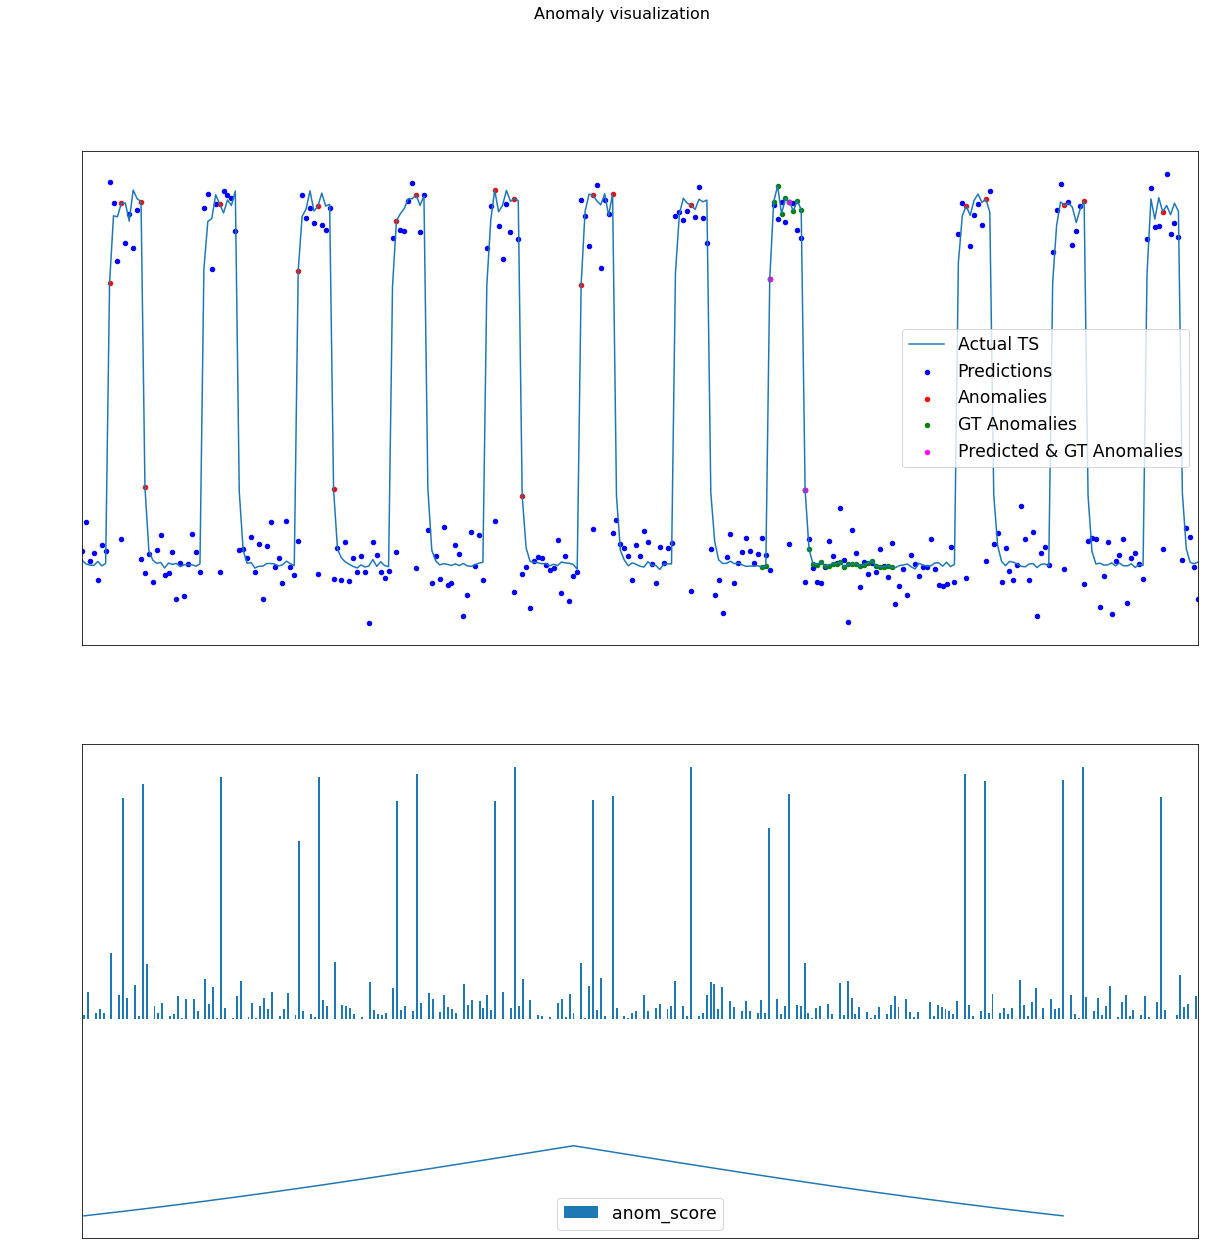

Customized score:  0.5329892332338859
31/31 [==============================] - ETA: 0s - loss: 3.3410e-04 - 1s 44ms/step - loss: 3.3335e-04 - val_loss: 2.6245e-04


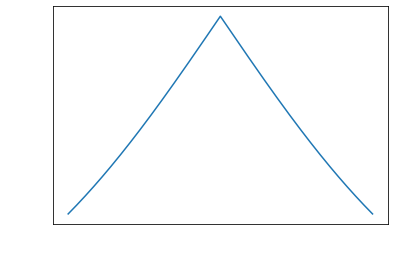

Epoch 44/50
19/31 [=================>............] - ETA: 0s - loss: 3.8889e-04 - ETA: 1s - loss: 3.3846e-04 - ETA: 1s - loss: 3.3953e-04 - ETA: 0s - loss: 3.4780e-04 - ETA: 0s - loss: 3.4241e-04 - ETA: 0s - loss: 3.3654e-04 - ETA: 0s - loss: 3.3250e-04 - ETA: 0s - loss: 3.2748e-04 - ETA: 0s - loss: 3.2470e-04 - ETA: 0s - loss: 3.2181e-04Model: "sequential_1"
___________________________________

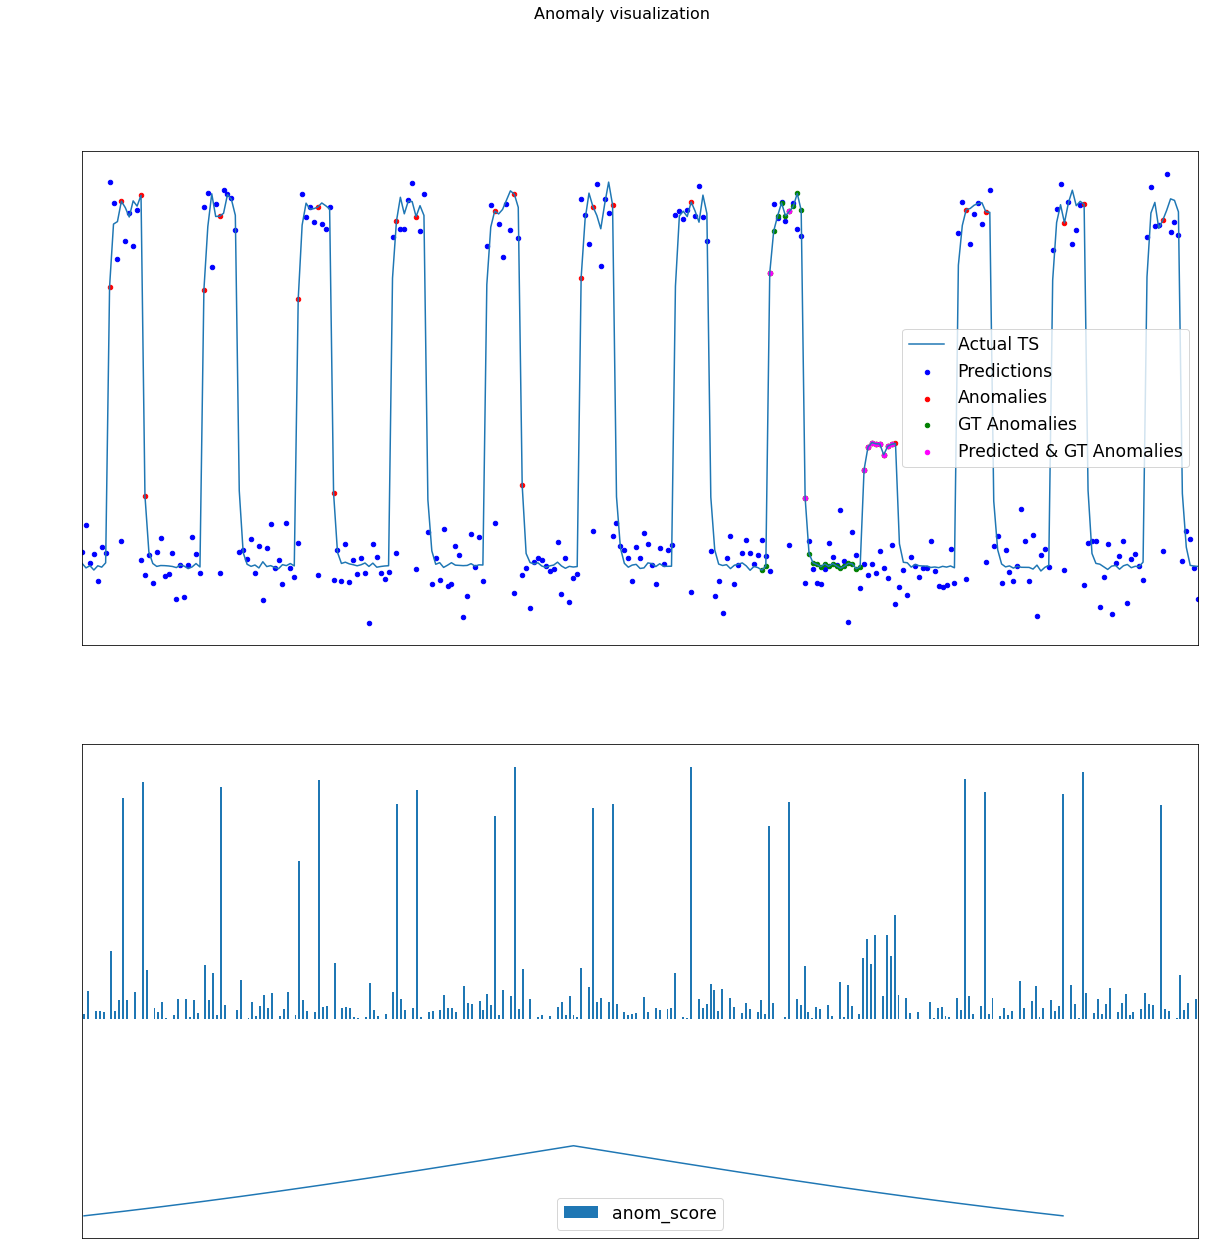

Customized score:  0.5368179049960607
0.058865129144131445
31/31 [==============================] - 1s 45ms/step - loss: 3.0898e-04 - val_loss: 2.0456e-04
Epoch 45/50
 3/31 [=>............................] - ETA: 1s - loss: 4.2568e-04 - ETA: 1s - loss: 3.5312e-04

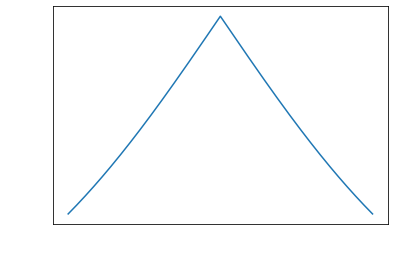

25/31 [=======================>......] - ETA: 0s - loss: 3.0271e-04 - ETA: 0s - loss: 2.8941e-04 - ETA: 0s - loss: 2.8487e-04 - ETA: 0s - loss: 2.8110e-04 - ETA: 0s - loss: 2.8094e-04 - ETA: 0s - loss: 2.7947e-04 - ETA: 0s - loss: 2.7755e-04 - ETA: 0s - loss: 2.7708e-04 - ETA: 0s - loss: 2.7753e-04 - ETA: 0s - loss: 2.7894e-04

<ipython-input-7-a71f714408fd>:16: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  return results_df.loc[test_df.index & results_df.index]


31/31 [==============================] - ETA: 0s - loss: 3.3047e-04 - ETA: 0s - loss: 3.3053e-04 - ETA: 0s - loss: 3.3084e-04 - ETA: 0s - loss: 3.3169e-04 - ETA: 0s - loss: 3.3275e-04 - ETA: 0s - loss: 3.3315e-04 - ETA: 0s - loss: 3.3359e-04 - ETA: 0s - loss: 3.3375e-04 - ETA: 0s - loss: 0.4737 - 1s 46ms/step - loss: 3.3369e-04 - val_loss: 2.0559e-04
Epoch 48/50
31/31 [==============================] - ETA: 1s - loss: 3.5815e-04

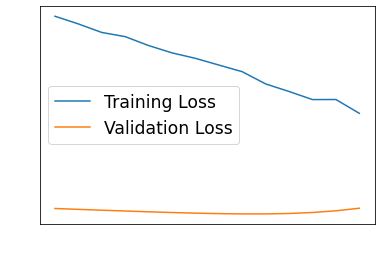

1/1 [==============================] - 0s 144ms/step - loss: 0.3725 - val_loss: 0.1129
Epoch 9/50
27/31 [=========================>....] - ETA: 0s - loss: 2.3900e-04Epoch 10/50
 - ETA: 0s - loss: 2.4282e-04 - ETA: 0s - loss: 2.4110e-0431/31 [==============================]1/1 [==============================] - 0s 139ms/step - loss: 0.3513 - val_loss: 0.1126
Epoch 11/50
1/1 [==============================] - 0s 127ms/step - loss: 0.3413 - val_loss: 0.1134
Epoch 12/50
1/1 [==============================] - ETA: 0s - loss: 0.3350 - 0s 185ms/step - loss: 0.3350 - val_loss: 0.1149
Epoch 13/50
1/1 [==============================] - ETA: 0s - loss: 0.3193

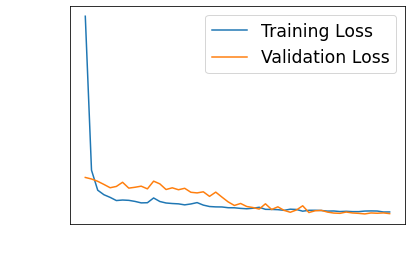

1/1 [==============================] - 0s 132ms/step - loss: 0.3193 - val_loss: 0.1174
Epoch 14/50
1/1 [==============================] - ETA: 0s - loss: 0.3171 - 0s 122ms/step - loss: 0.3171 - val_loss: 0.1208


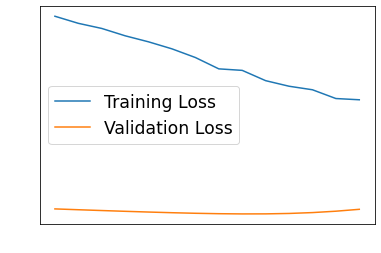

<ipython-input-9-660c86c91a15>:16: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  return results_df.loc[test_df.index & results_df.index]
<ipython-input-9-660c86c91a15>:16: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  return results_df.loc[test_df.index & results_df.index]


0.011842558816325744
0.0


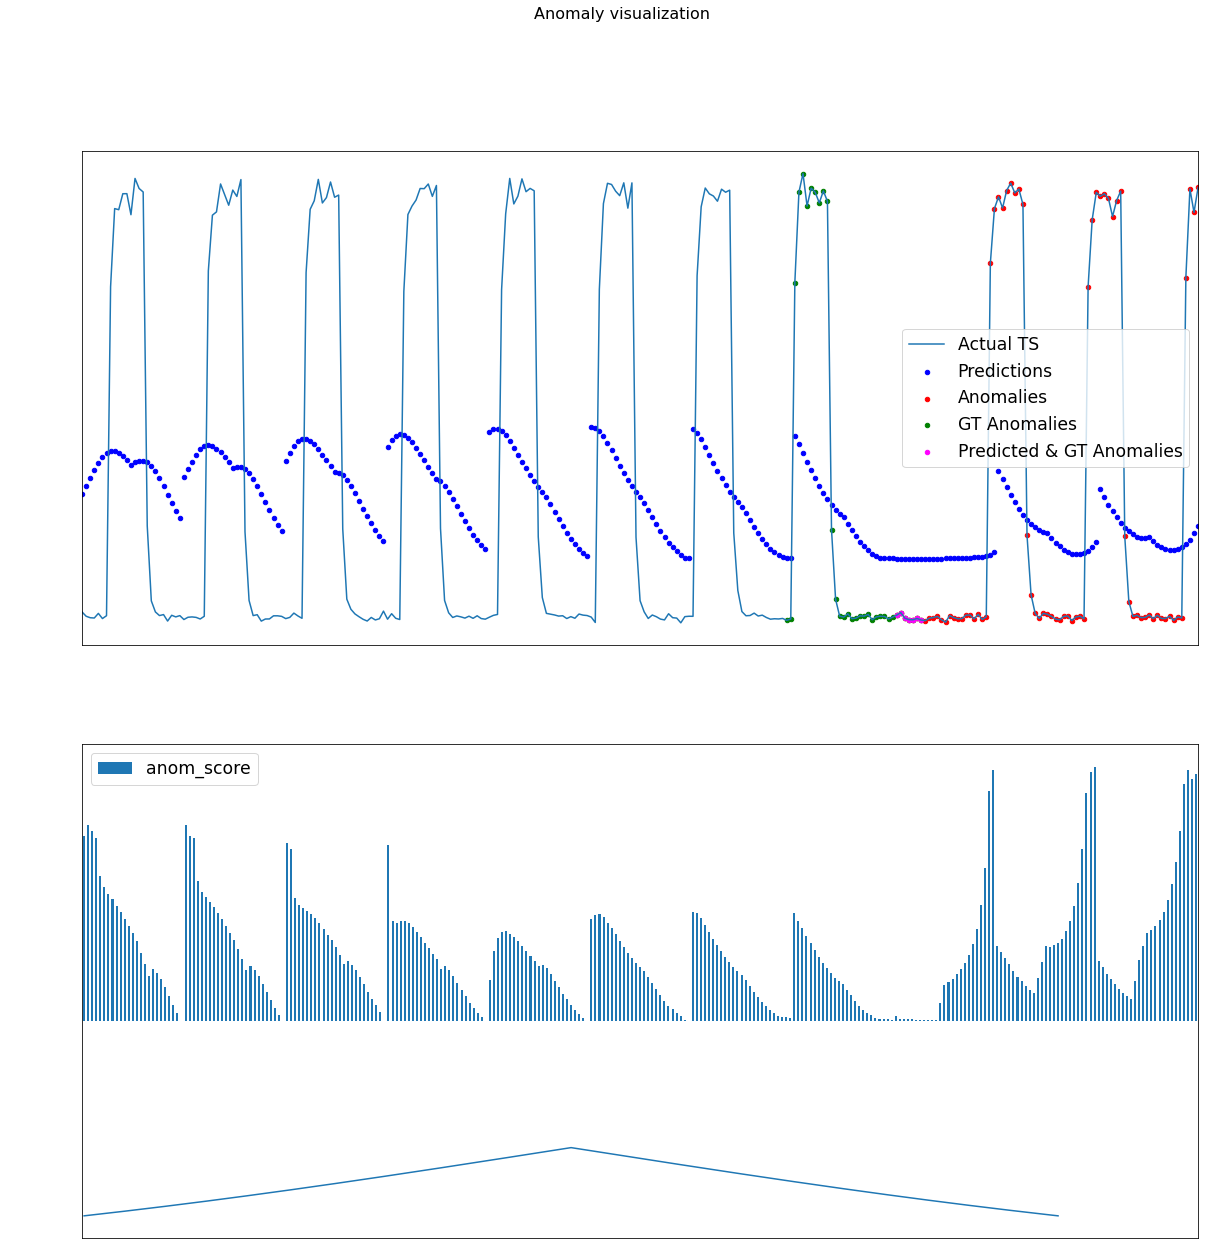

Customized score:  0.37173002962269036
0.011842558816325744


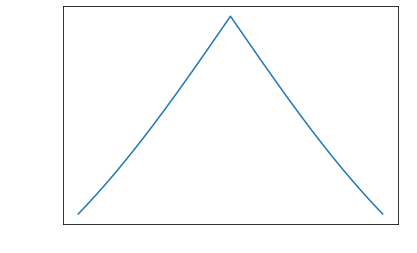

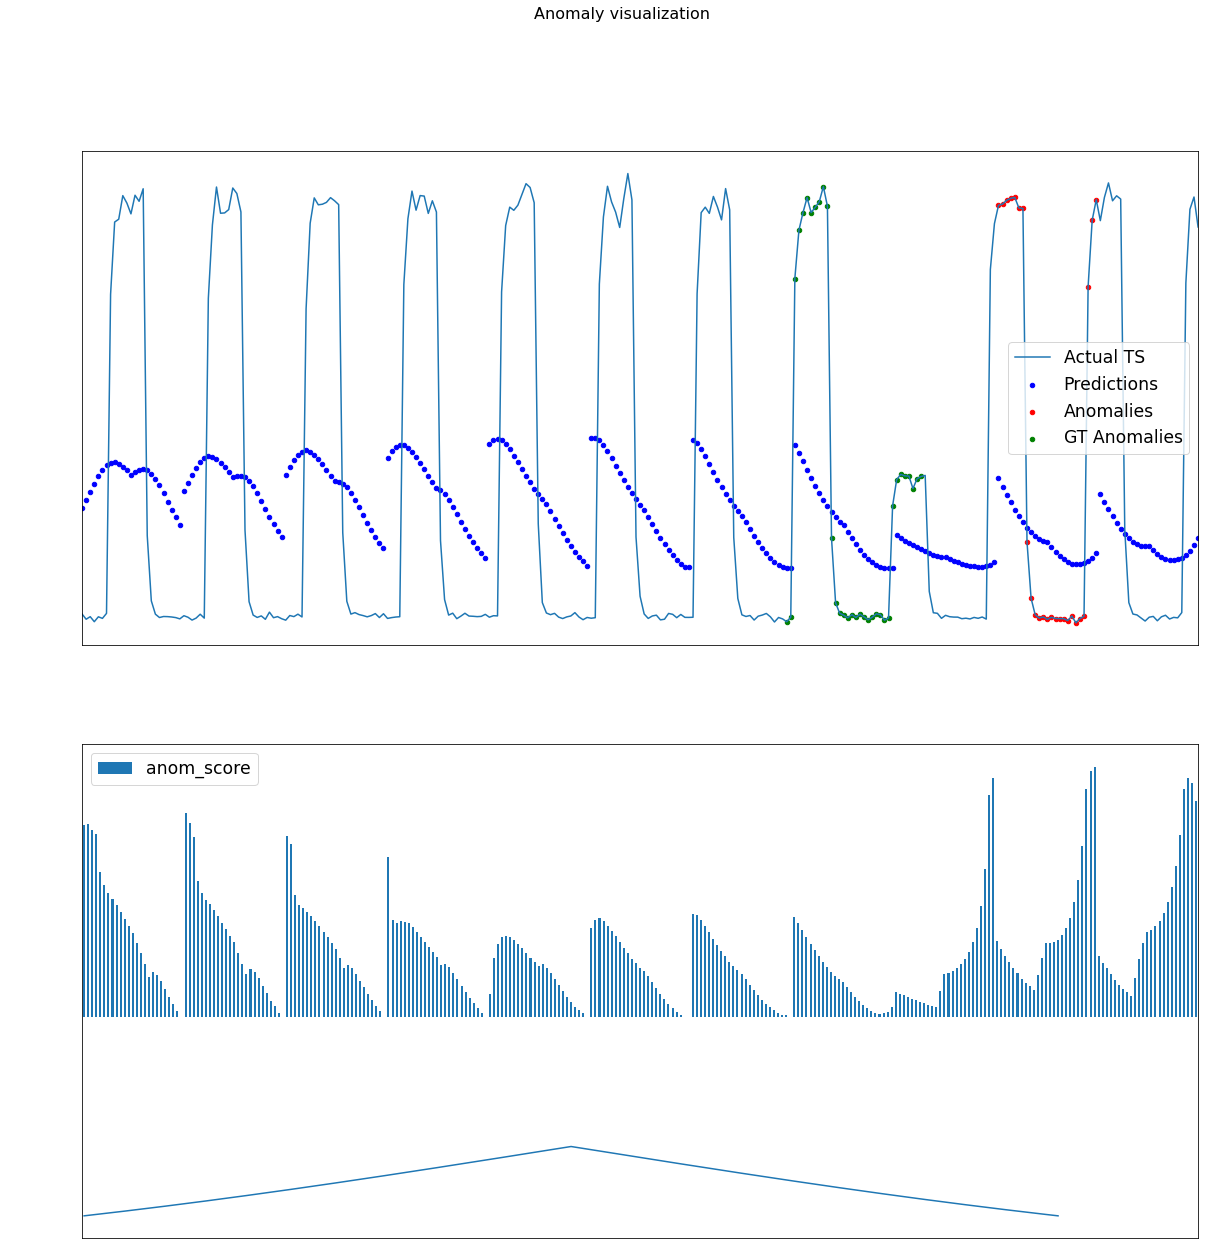

Customized score:  0.2958570358844573
0.0


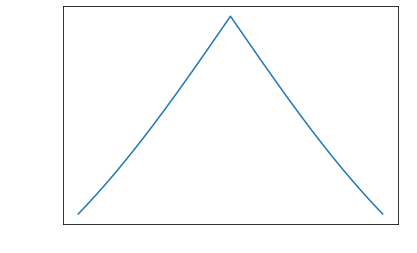

<ipython-input-7-a71f714408fd>:16: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  return results_df.loc[test_df.index & results_df.index]


0.0


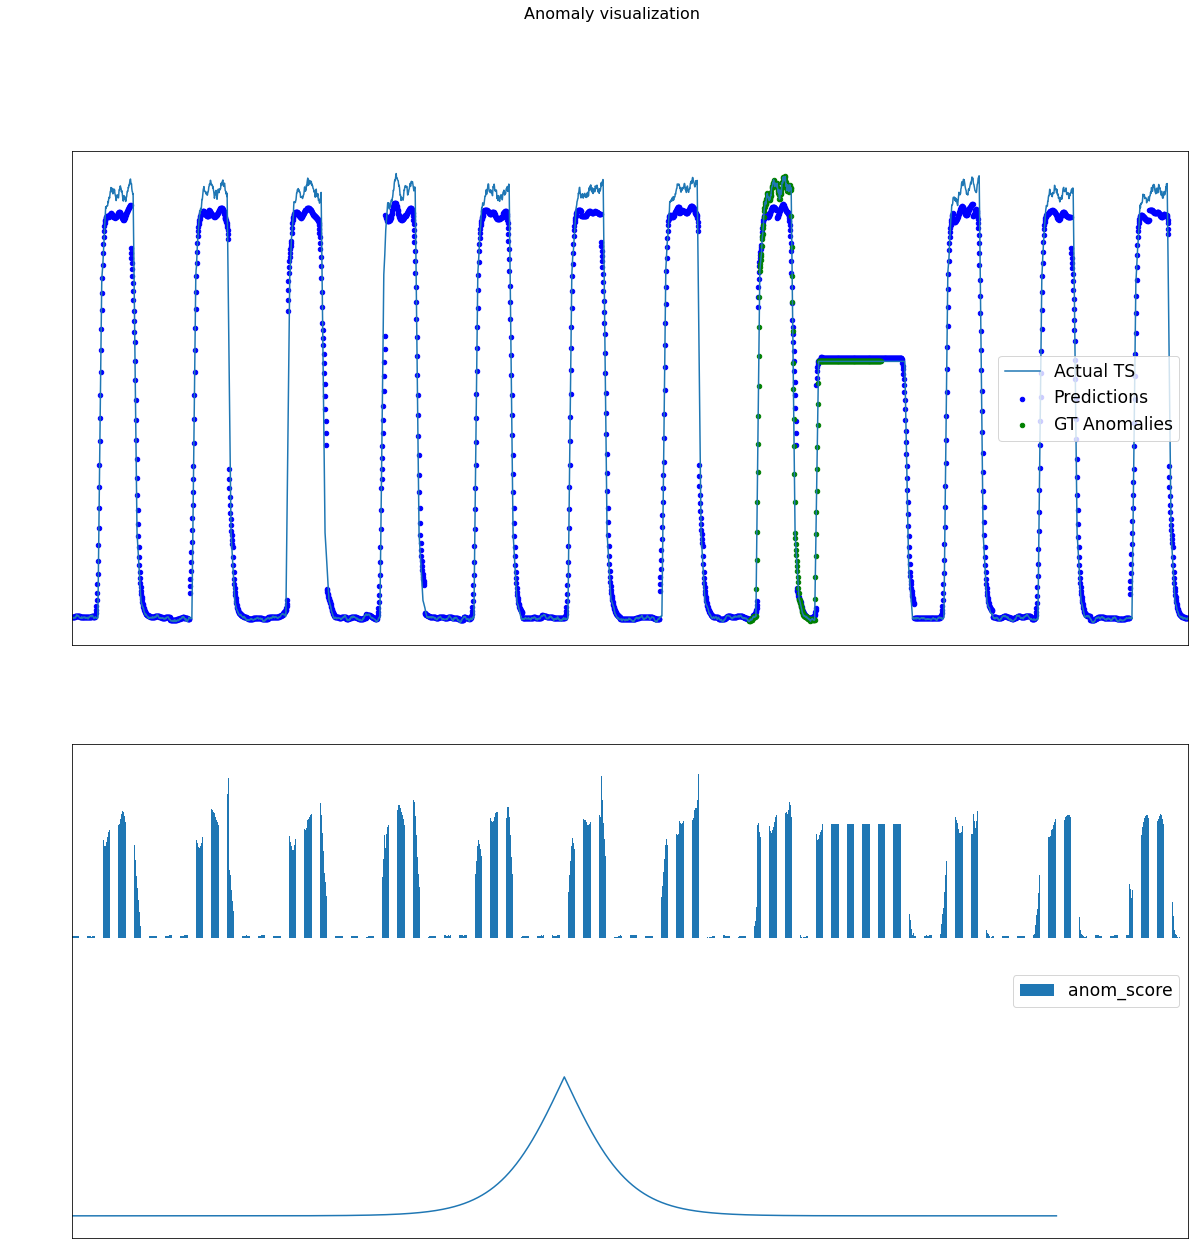

Customized score:  0.3333333333333333
0.0


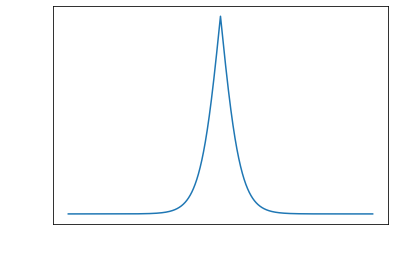

2.304370407569737e-14


<ipython-input-8-2e85185fa41f>:16: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  return results_df.loc[test_df.index & results_df.index]


1.2181235674124362


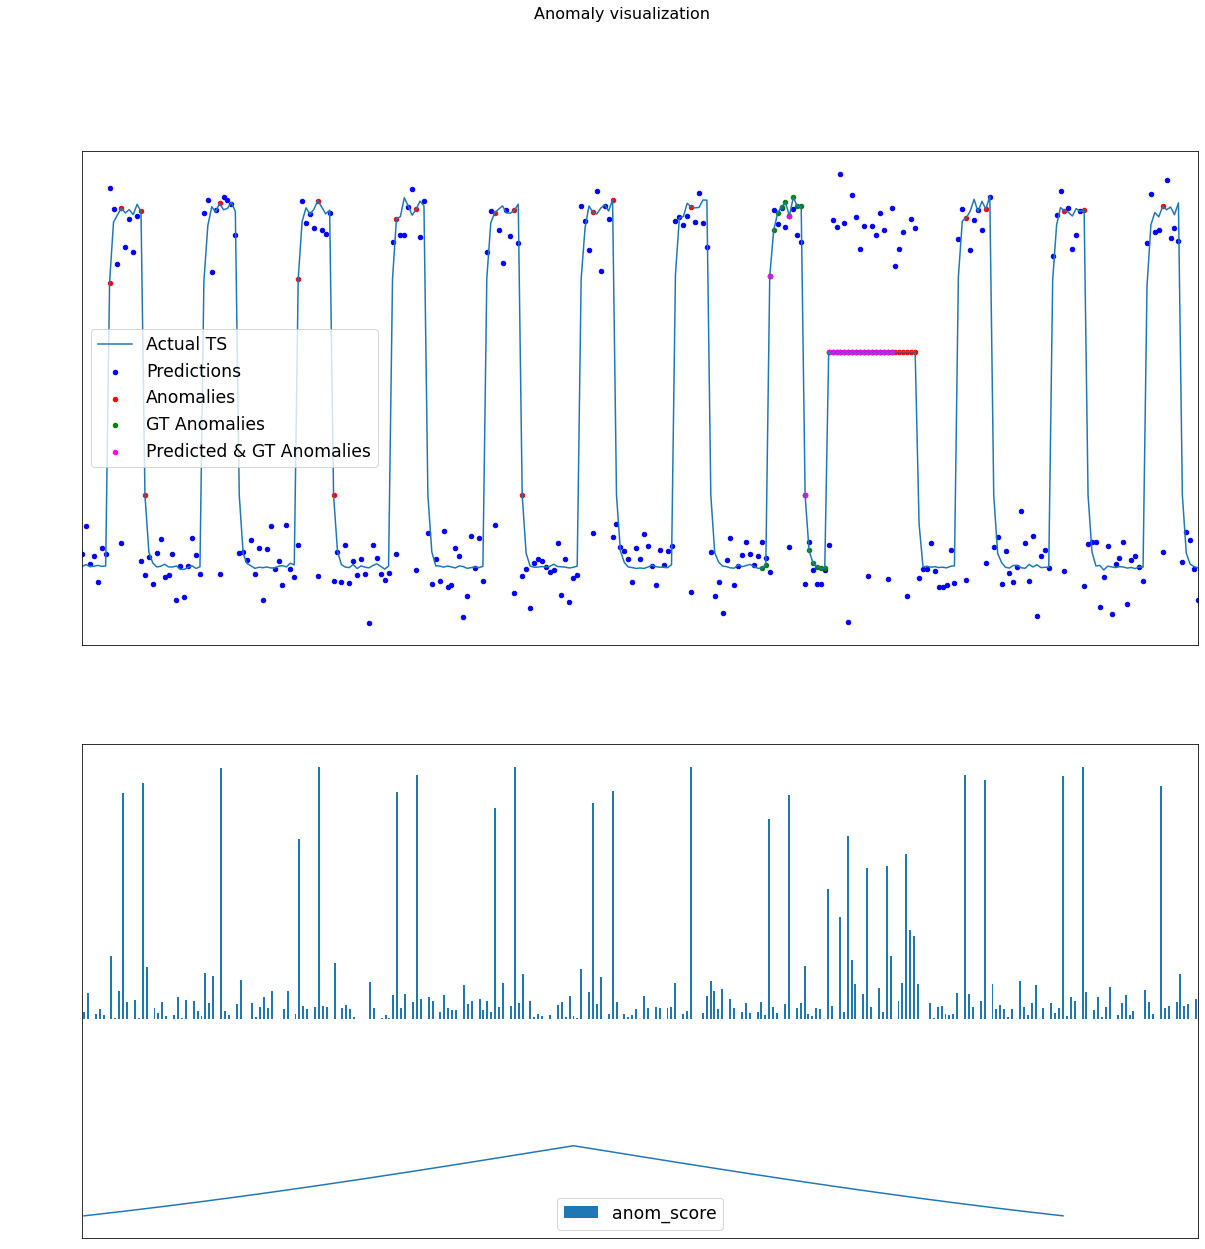

Customized score:  0.9642801537402589
1.2181235674124362


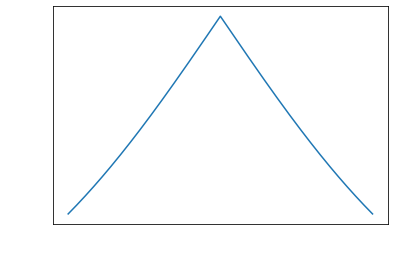

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 12, 64)            16896     
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 49,985
Trainable params: 49,985
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
1/1 [==============================] - ETA: 0s - loss: 0.5378 - 4s 4s/step - loss: 0.5378 - val_loss: 0.1203
Epoch 2/50
1/1 [==============================] - ETA: 0s - loss: 0

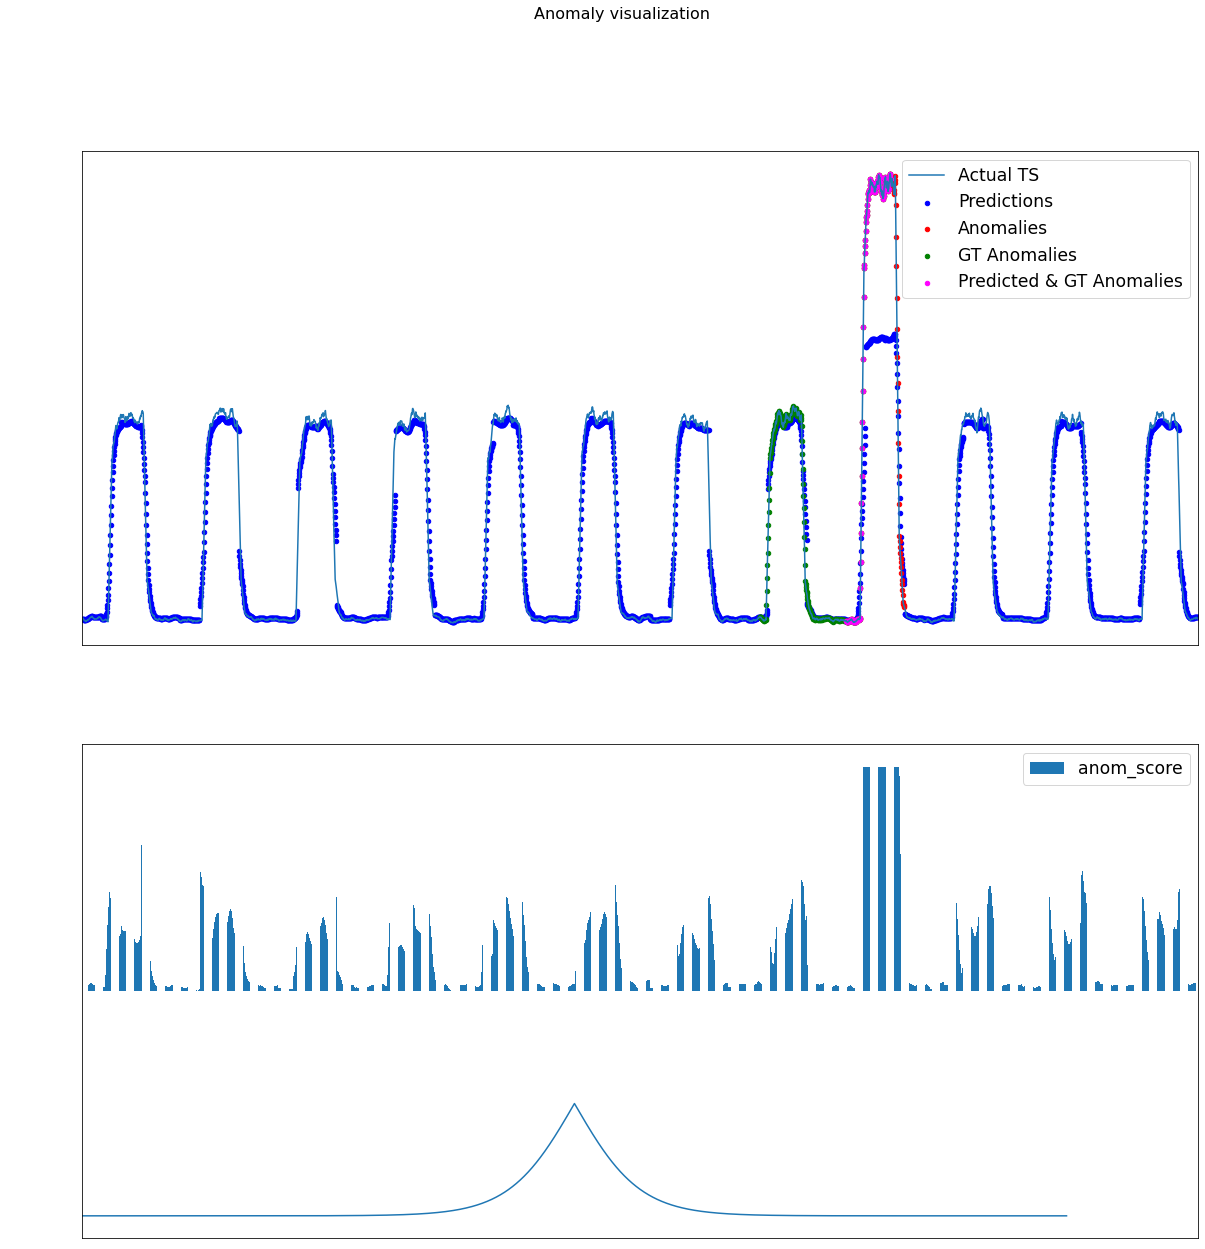

Customized score:  0.5556805391278267
2.304370407569737e-14


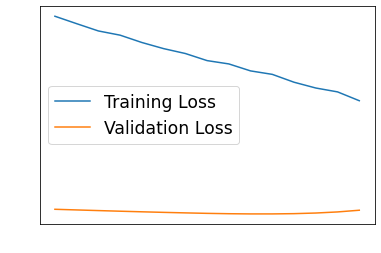

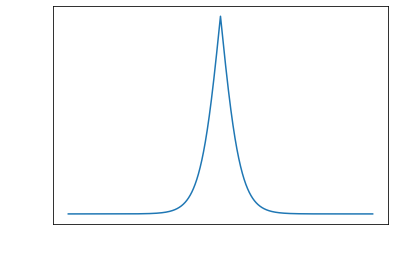

<ipython-input-8-2e85185fa41f>:16: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  return results_df.loc[test_df.index & results_df.index]
<ipython-input-9-660c86c91a15>:16: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  return results_df.loc[test_df.index & results_df.index]


0.058865129144131445
0.011842558816325744


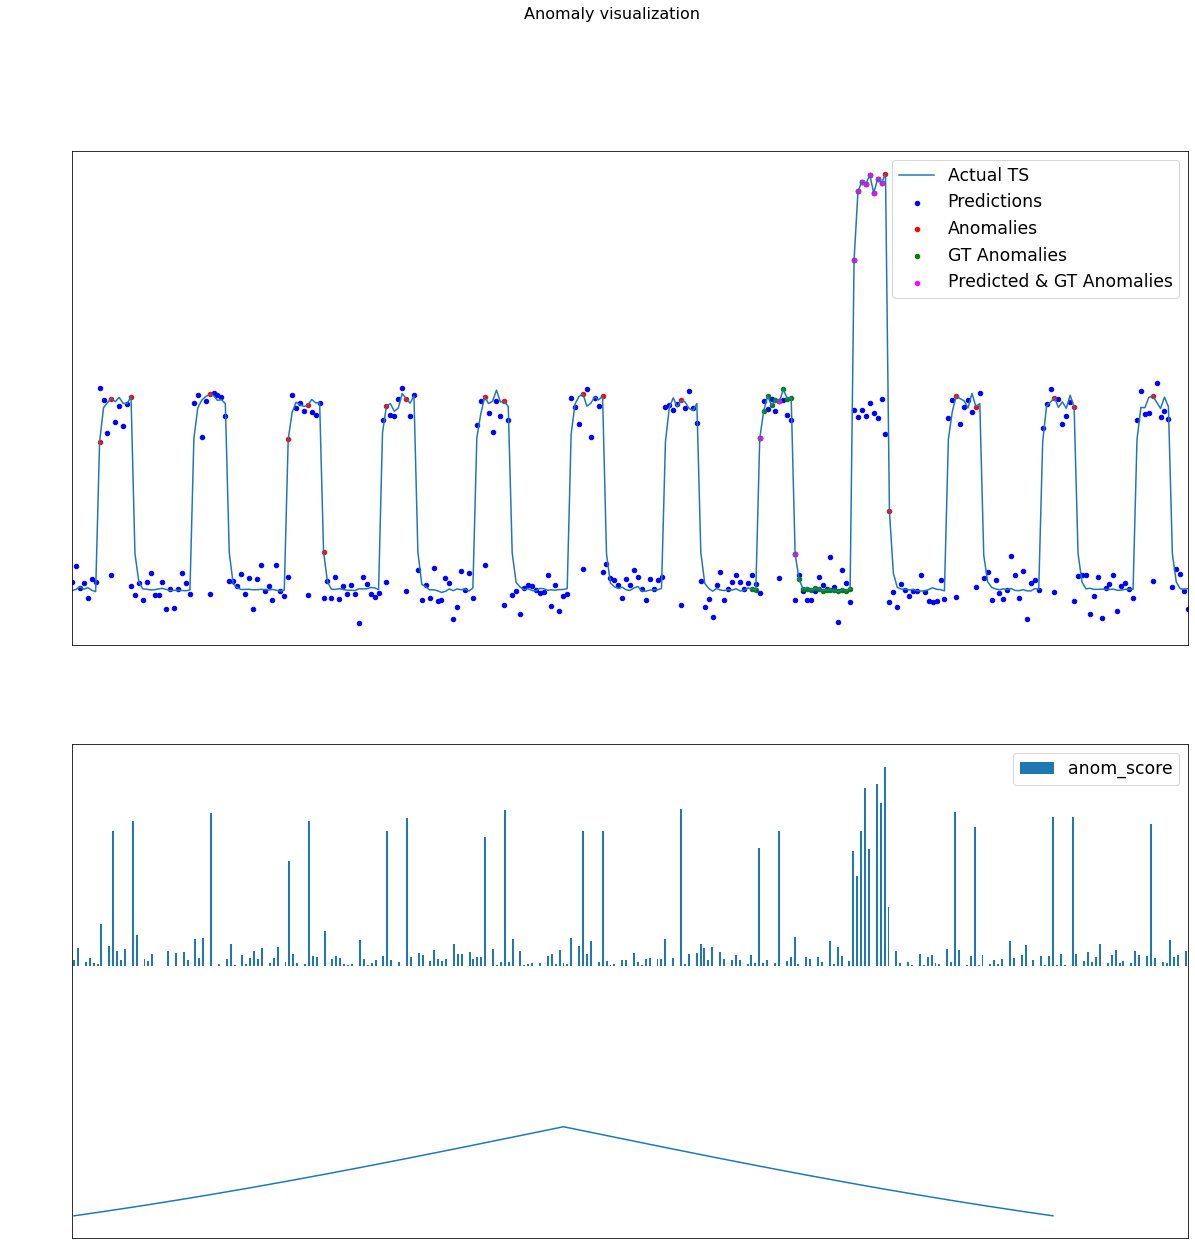

Customized score:  0.540683422945733
0.058865129144131445


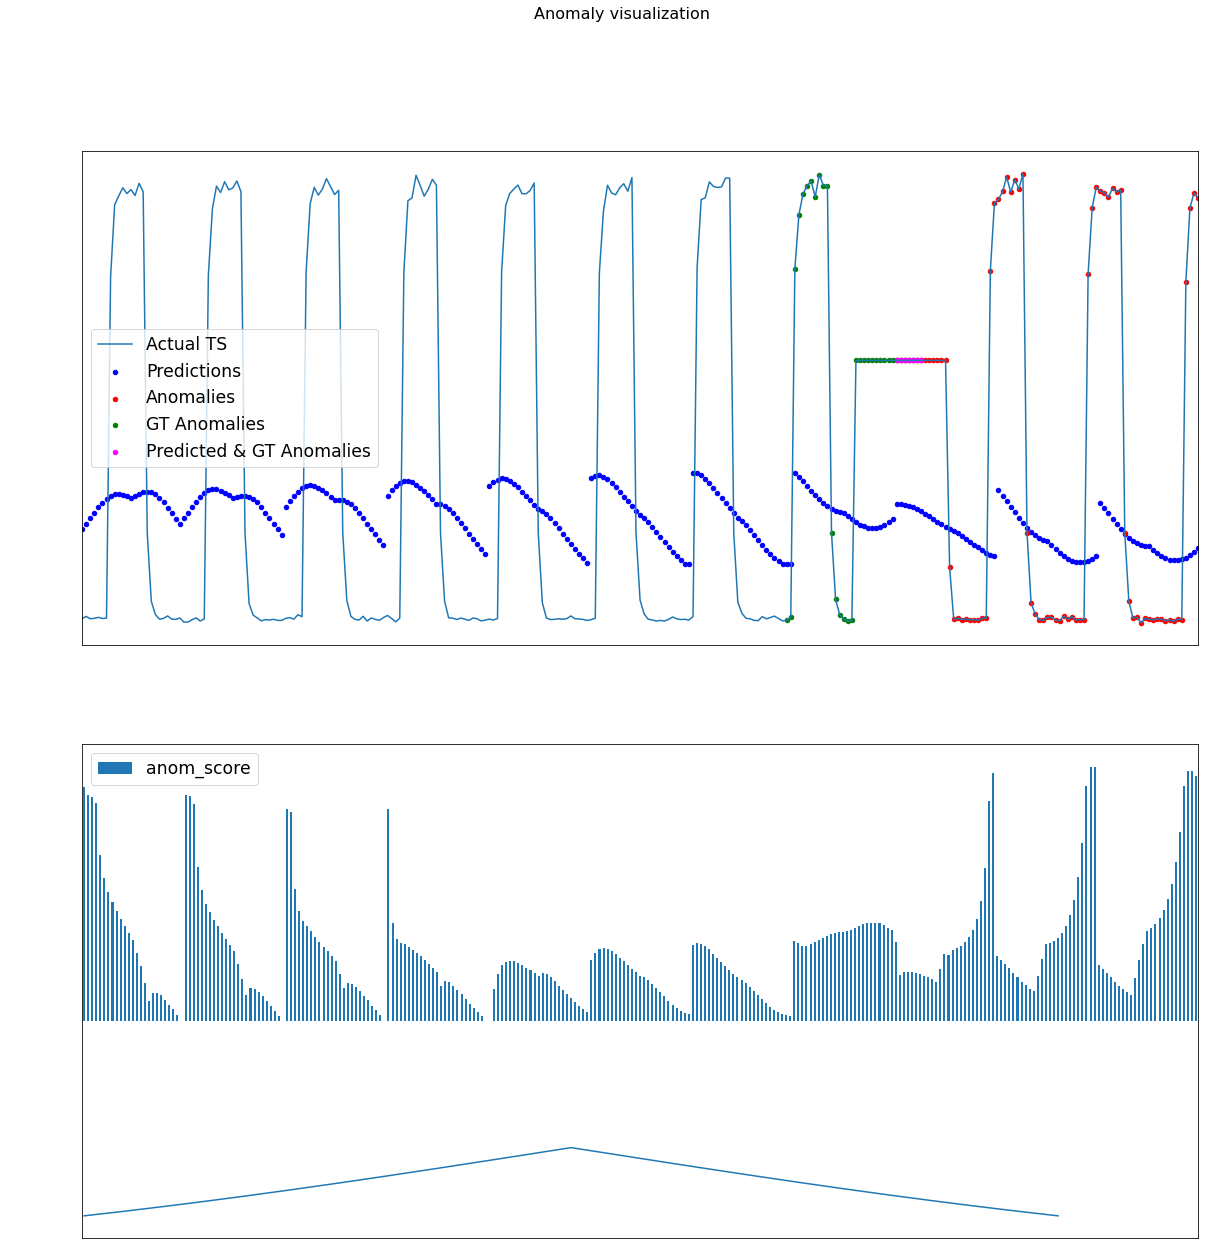

Customized score:  0.37173002962269036
0.011842558816325744


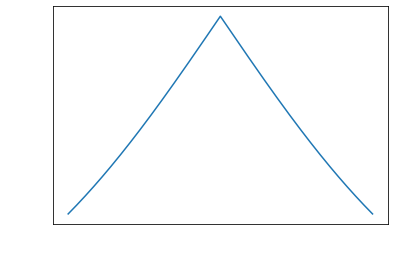

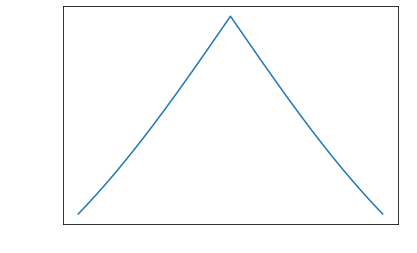

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 12, 64)            16896     
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 49,985
Trainable params: 49,985
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
1/1 [==============================] - ETA: 0s - loss: 0.1224 - 4s 4s/step - loss: 0.1224 - val_loss: 0.0269
Epoch 2/50
1/1 [==============================] - ETA: 0s - loss: 0

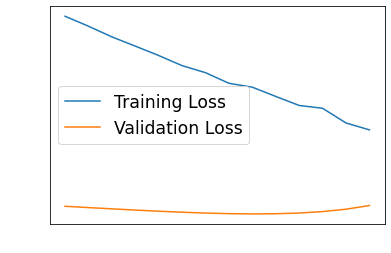

<ipython-input-9-660c86c91a15>:16: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  return results_df.loc[test_df.index & results_df.index]


1.9877715854977227


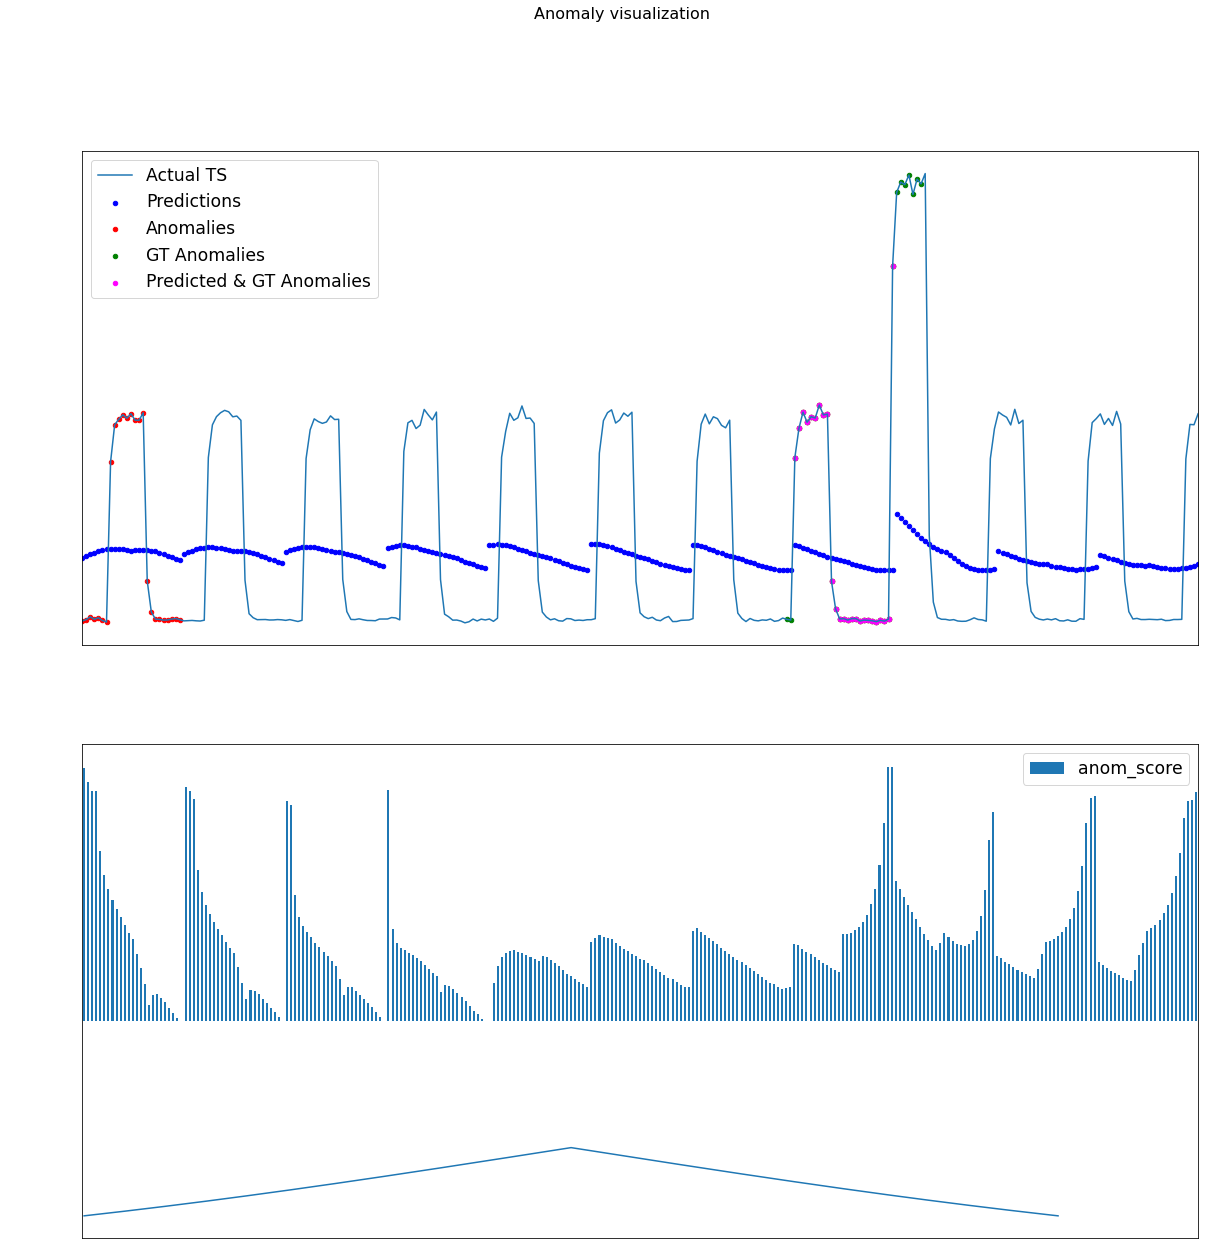

Customized score:  0.959825929282987
1.9877715854977227


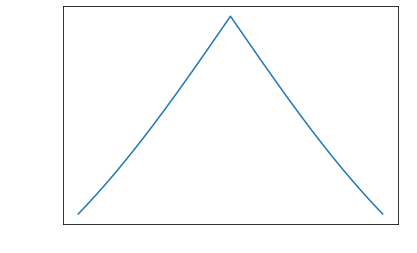

after reading csv
after reading csv
after reading csv
after reading csv


<ipython-input-17-2d1d4f21c0ec>:17: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  return results_df.loc[test_df.index & results_df.index]
<ipython-input-17-2d1d4f21c0ec>:17: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  return results_df.loc[test_df.index & results_df.index]
<ipython-input-17-2d1d4f21c0ec>:17: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  return results_df.loc[test_df.index & results_df.index]
<ipython-input-17-2d1d4f21c0ec>:17: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching S

0.032592244523068956
0.032592244523068956
1.9928049681268099
1.9928049681268099


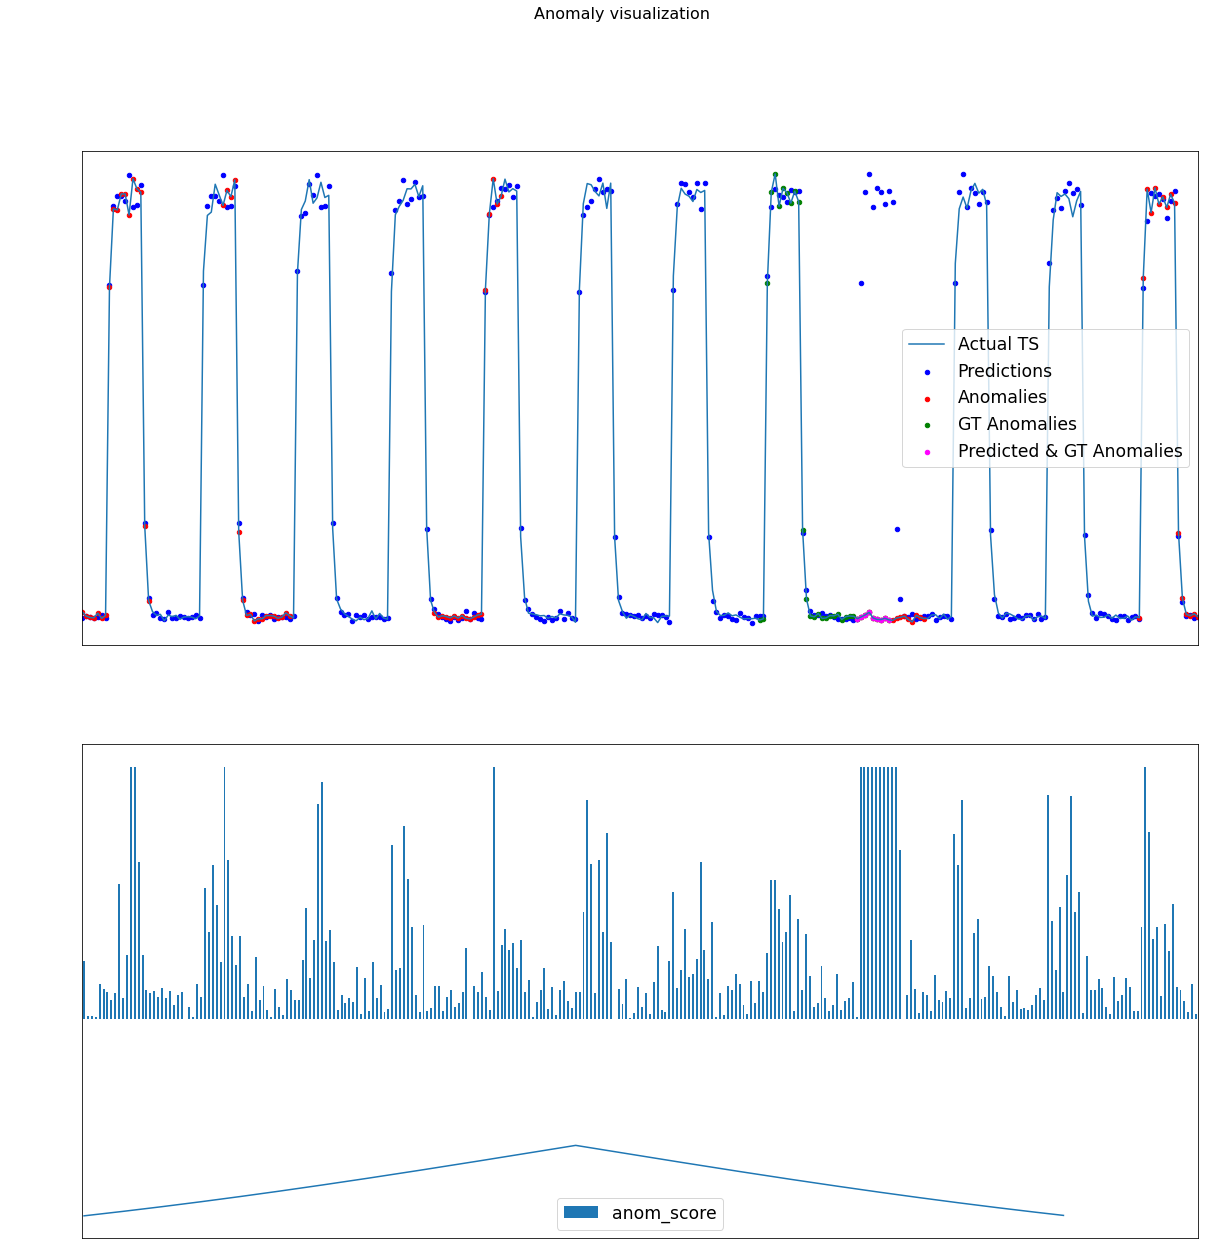

Customized score:  0.409835821168907
0.032592244523068956


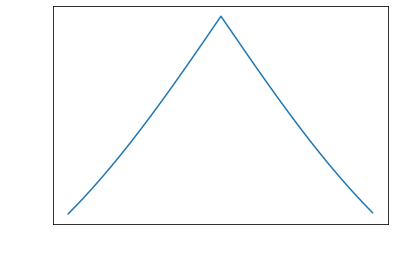

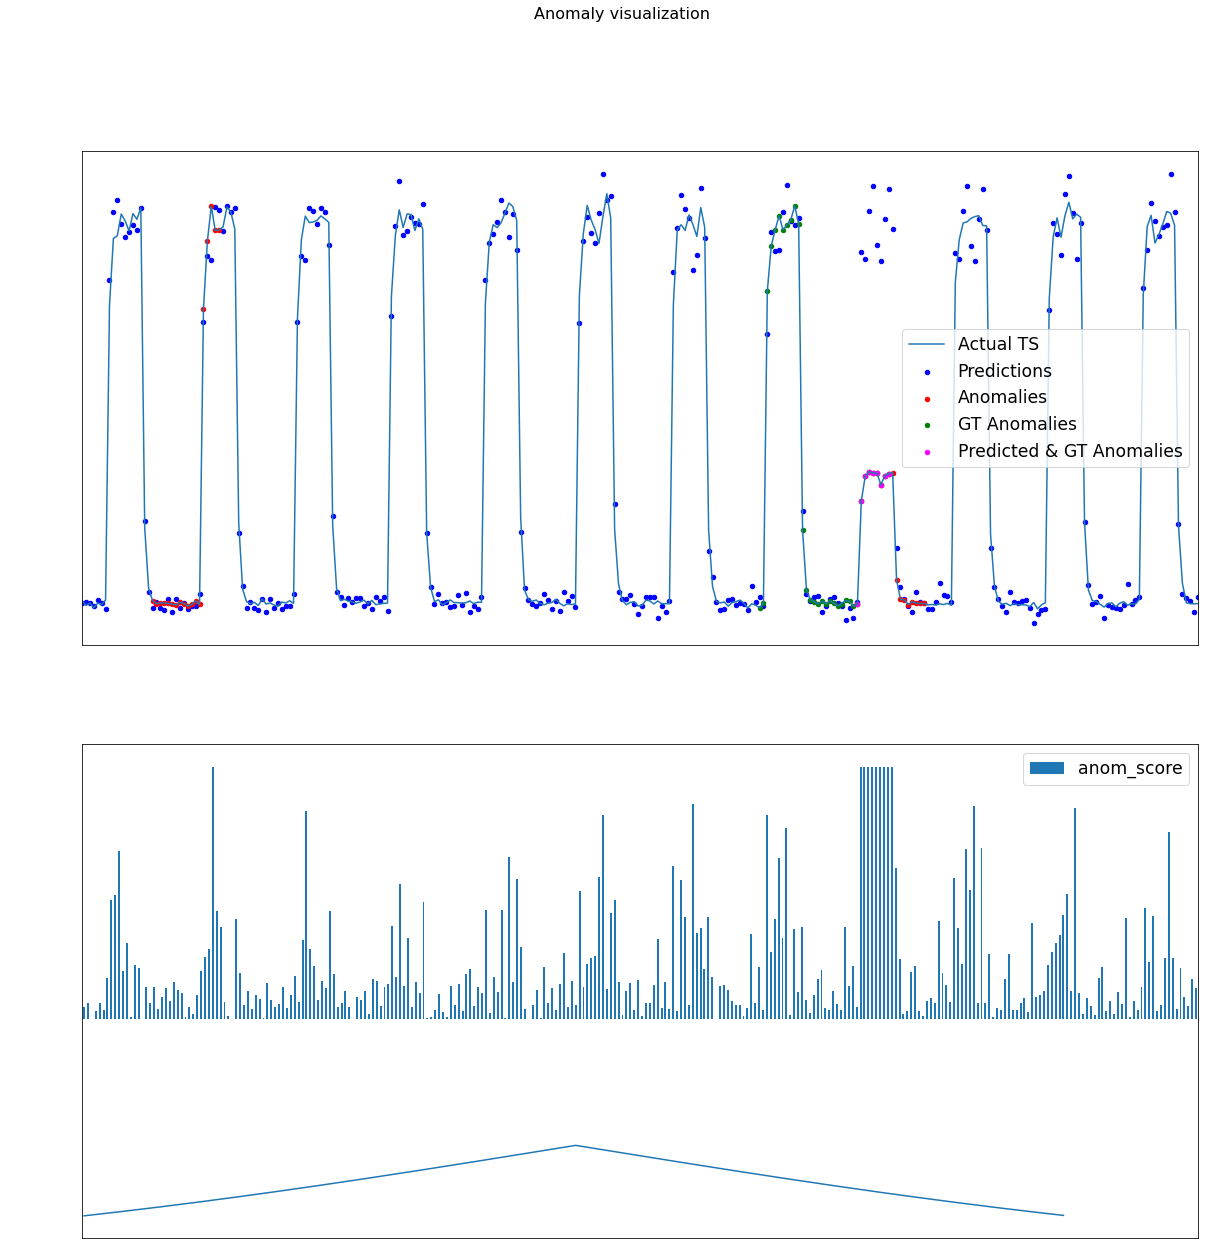

Customized score:  0.4823728793047665
0.032592244523068956


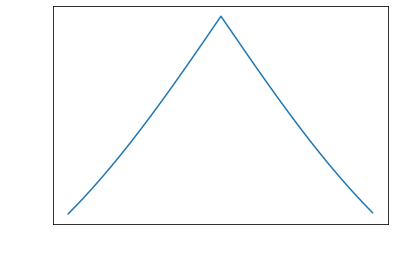

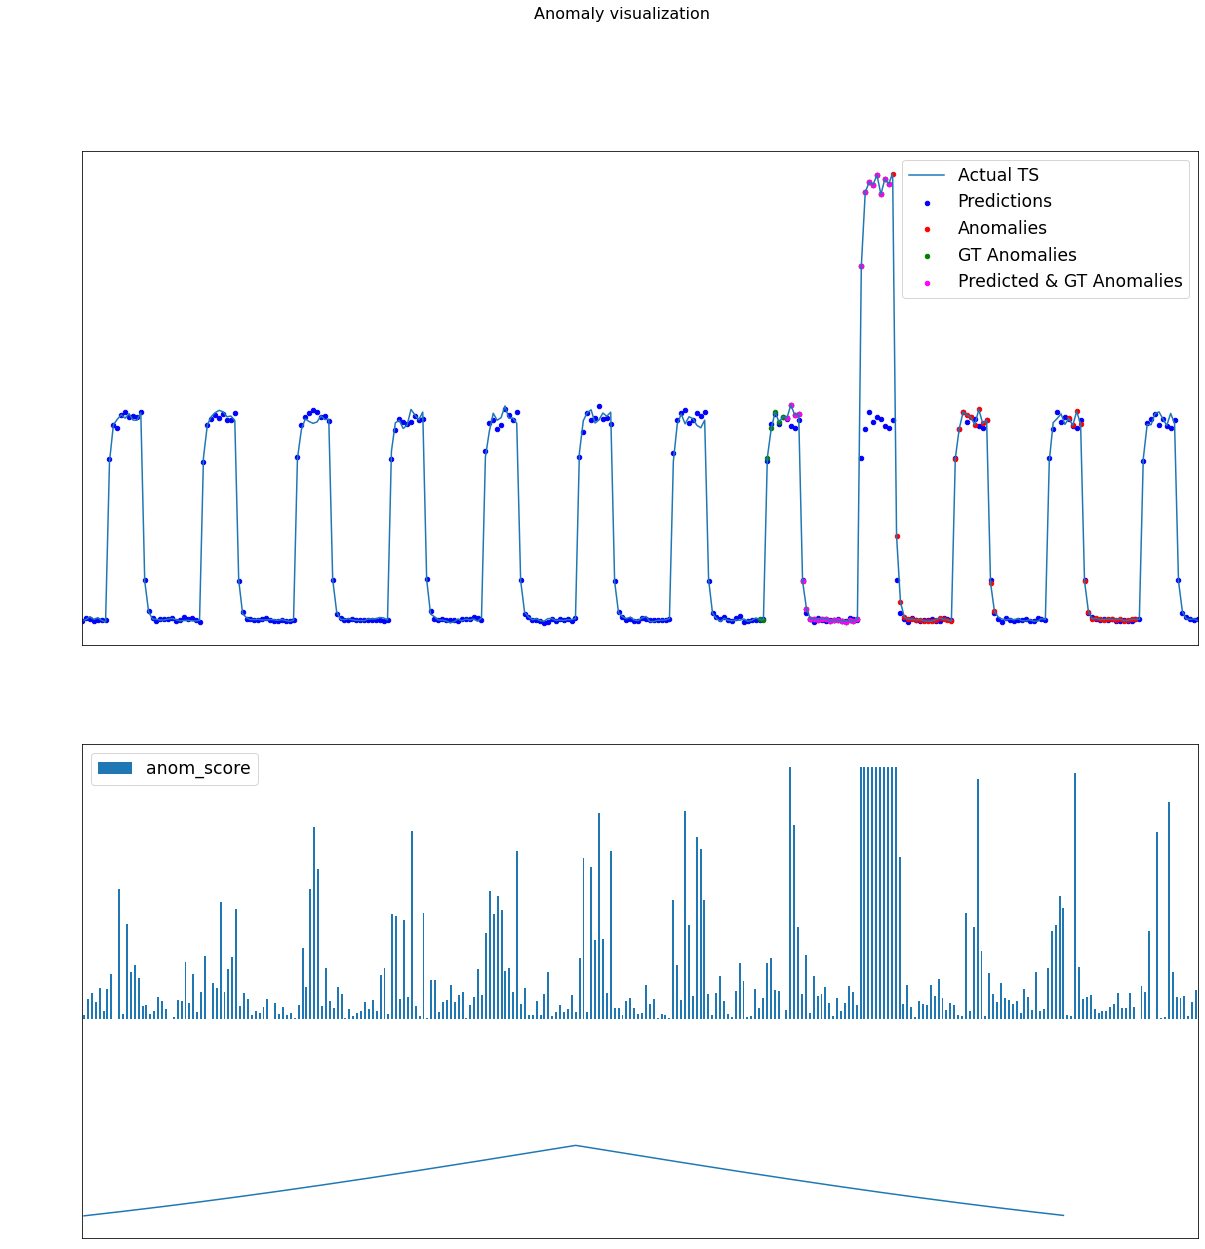

Customized score:  0.937539419185911
1.9928049681268099


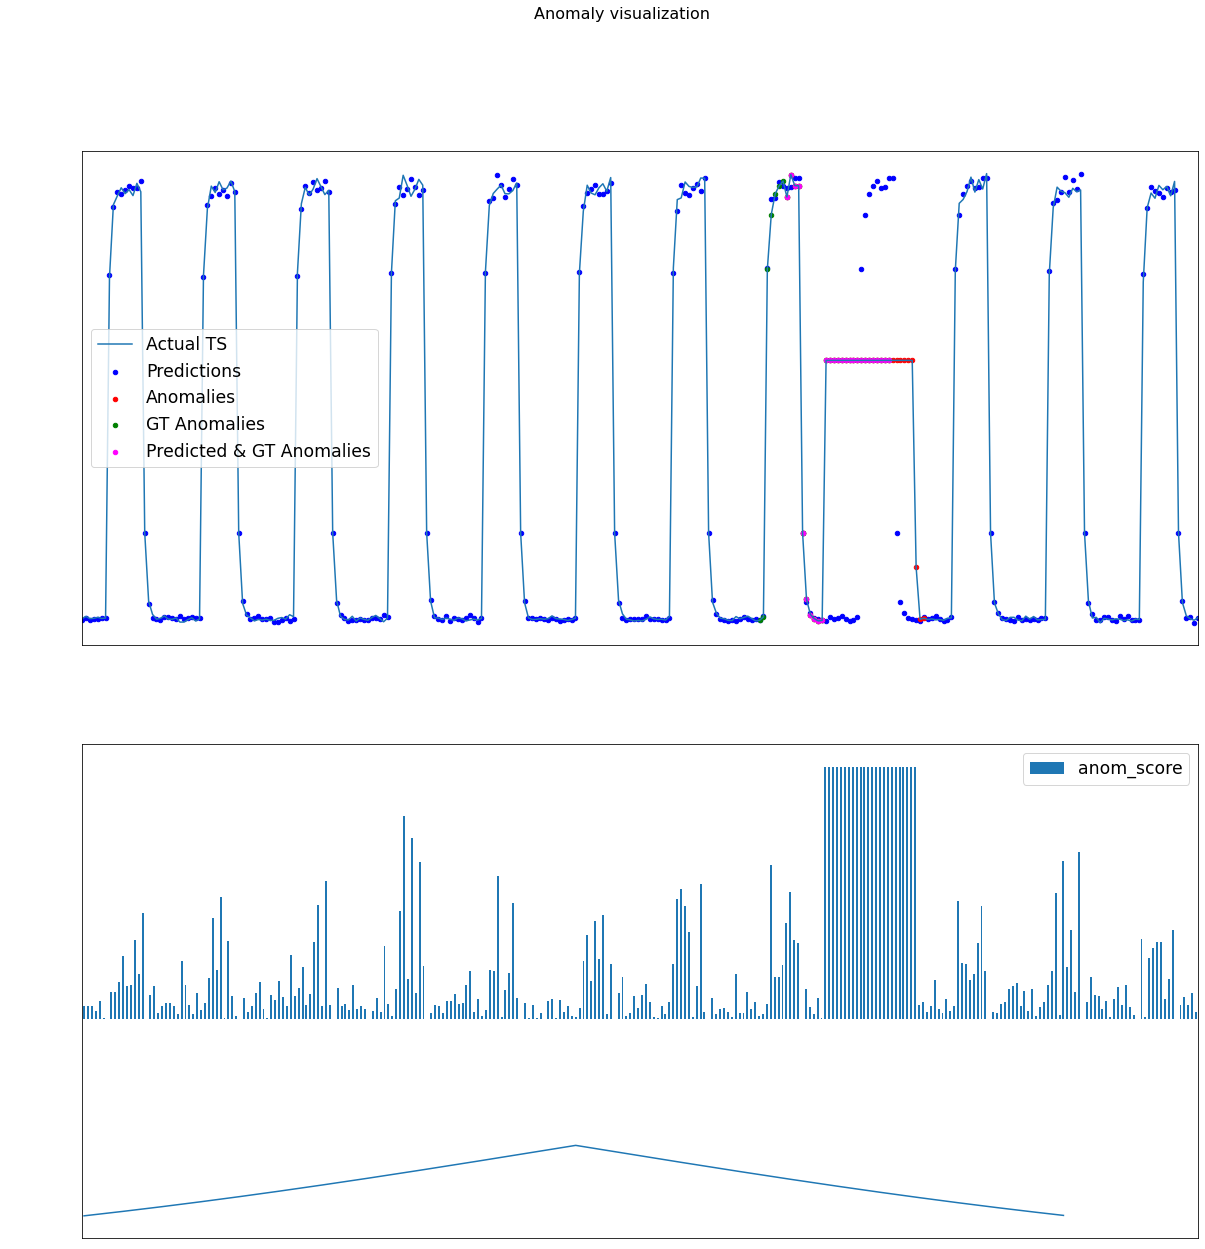

Customized score:  0.988522862463709
1.9928049681268099


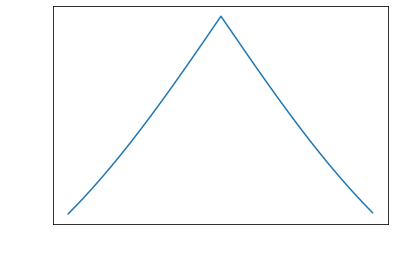

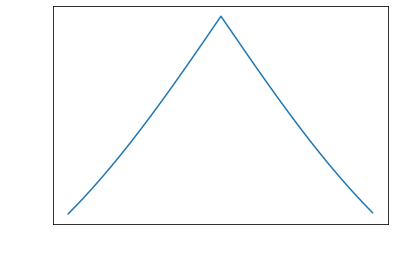

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               66560     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
repeat_vector (RepeatVector) (None, 12, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 12, 128)           131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 128)           0         
_________________________________________________________________
time_distributed (TimeDistri (None, 12, 1)             129       
Total params: 198,273
Trainable params: 198,273
Non-trainable params: 0
__________________________________________________

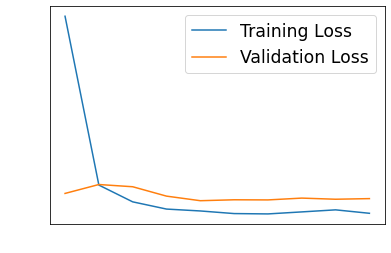

31/31 [==============================] - ETA: 1s - loss: 0.0045 5/31 [===>..........................]13/31 [===========>..................] - ETA: 0s - loss: 0.0016 - ETA: 1s - loss: 0.0045 - ETA: 0s - loss: 0.004314/31 [============>.................] - ETA: 0s - loss: 0.0016 - ETA: 0s - loss: 0.0043 6/31 [====>.........................] - ETA: 1s - loss: 0.0044 7/31 [=====>........................] - ETA: 1s - loss: 0.0044 - ET

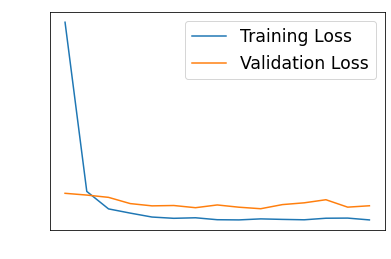

31/31 [==============================] - ETA: 0s - loss: 6.6166e-04 - ETA: 0s - loss: 0.0040 - ETA: 0s - loss: 0.0041 - ETA: 0s - loss: 6.7603e-04 - ETA: 0s - loss: 6.9142e-04 - ETA: 0s - loss: 0.0041 - ETA: 0s - loss: 0.0041 - ETA: 0s - loss: 6.9893e-04 - ETA: 0s - loss: 7.0328e-04 - ETA: 0s - loss: 0.0041 - ETA: 0s - 

<ipython-input-18-a71f714408fd>:16: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  return results_df.loc[test_df.index & results_df.index]


31/31 [==============================] 9/31 [=======>......................] - ETA: 0s - loss: 9.8717e-04 - ETA: 0s - loss: 0.002511/31 [=========>....................] - ETA: 0s - loss: 0.0025 - ETA: 0s - loss: 8.9563e-04 - ETA: 0s - loss: 0.0026 - ETA: 0s - loss: 8.4973e-04 - ETA: 0s - loss: 0.0027 - ETA: 0s - loss: 8.2744e-04 - ETA: 0s - loss: 0.0027 - ETA: 0s - loss: 8.2862e-04

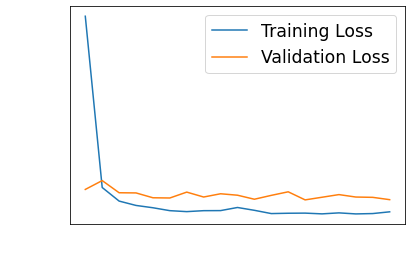

31/31 [==============================] - ETA: 0s - loss: 0.0023 - ETA: 0s - loss: 0.0023 - ETA: 0s - loss: 0.0023 - ETA: 0s - loss: 0.0023 - ETA: 0s - loss: 0.0024 - ETA: 0s - loss: 0.0024 - ETA: 0s - loss: 0.0024 - 1s 34ms/step - loss: 0.0024 - val_loss: 0.0051
Epoch 21/50
30/31 [============================>.] - ETA: 0s - loss: 0.0027 - ETA: 1s - loss: 0.0022 - ETA: 0s - loss: 0.0022

<ipython-input-18-a71f714408fd>:16: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  return results_df.loc[test_df.index & results_df.index]


31/31 [==============================] - 1s 35ms/step - loss: 0.0025 - val_loss: 0.0029
Epoch 22/50
31/31 [==============================] - ETA: 0s - loss: 0.0012 - ETA: 0s - loss: 0.0013 - ETA: 0s - loss: 0.0016 - ETA: 0s - loss: 0.0018 - ETA: 0s - loss: 0.0019 - ETA: 0s - loss: 0.0020 - ETA: 0s - loss: 0.0020 - ETA: 0s - loss: 0.0021 - ETA: 0s - loss: 0.0022 - ETA: 0s - loss: 0.0022

<ipython-input-18-a71f714408fd>:16: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  return results_df.loc[test_df.index & results_df.index]


31/31 [==============================] - 2s 55ms/step - loss: 0.0013 - val_loss: 0.0020
Epoch 27/50
31/31 [==============================] - ETA: 0s - loss: 0.0024 - 2s 50ms/step - loss: 0.0024 - val_loss: 0.0017
Epoch 28/50
31/31 [==============================] - ETA: 1s - loss: 9.3279e-04 - ETA: 1s - loss: 0.0024     - ETA: 1s - loss: 0.0035 - ETA: 1s - loss: 0.0036 - ETA: 0s - loss: 0.0037 - ETA: 0s - loss: 0.0037 - ETA: 0s - loss: 0.0038

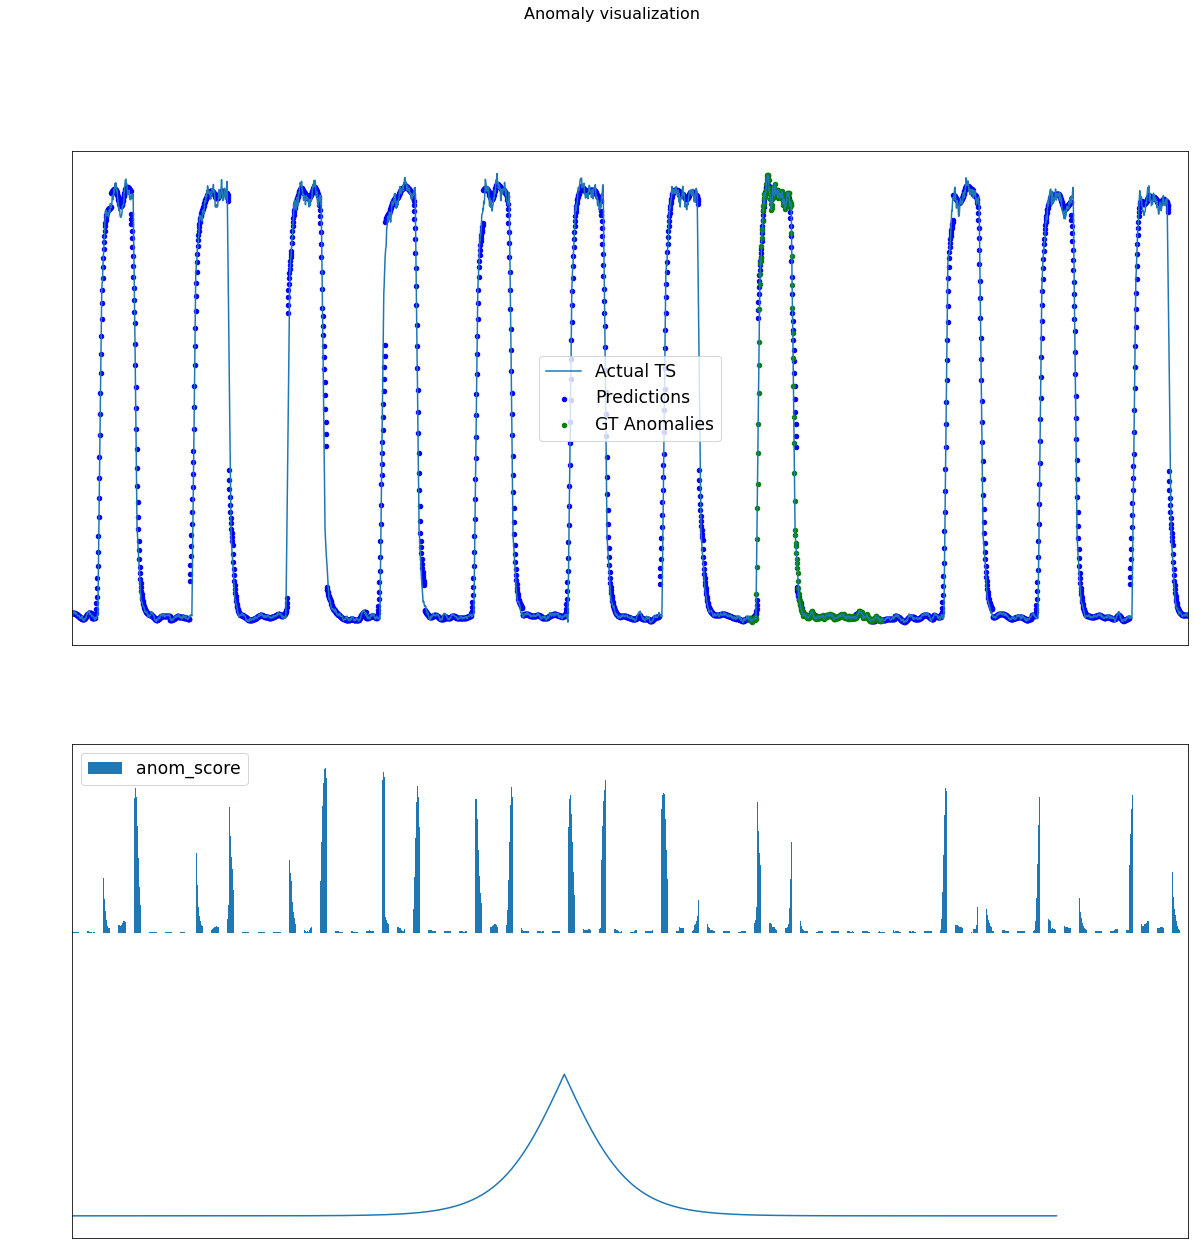

Customized score:  0.3333333333333333
0.0
22/31 [====================>.........] - ETA: 0s - loss: 0.0016 - ETA: 0s - loss: 0.0016 - ETA: 0s - loss: 0.0015 - ETA: 0s - loss: 0.0015

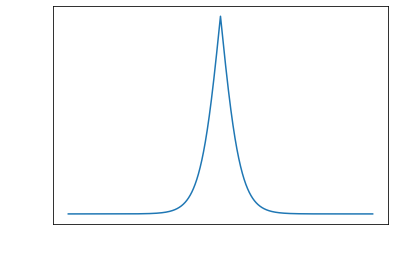

31/31 [==============================] - ETA: 0s - loss: 0.0015 - ETA: 0s - loss: 0.0015 - ETA: 0s - loss: 0.0015 - ETA: 0s - loss: 0.0015 - 1s 34ms/step - loss: 0.0015 - val_loss: 0.0032
2.304370407569737e-14


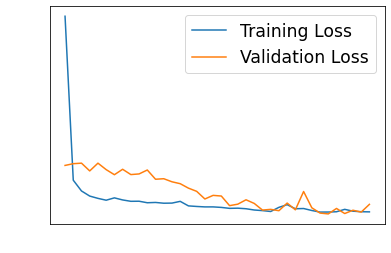

<ipython-input-19-2e85185fa41f>:16: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  return results_df.loc[test_df.index & results_df.index]


0.039154058065167516


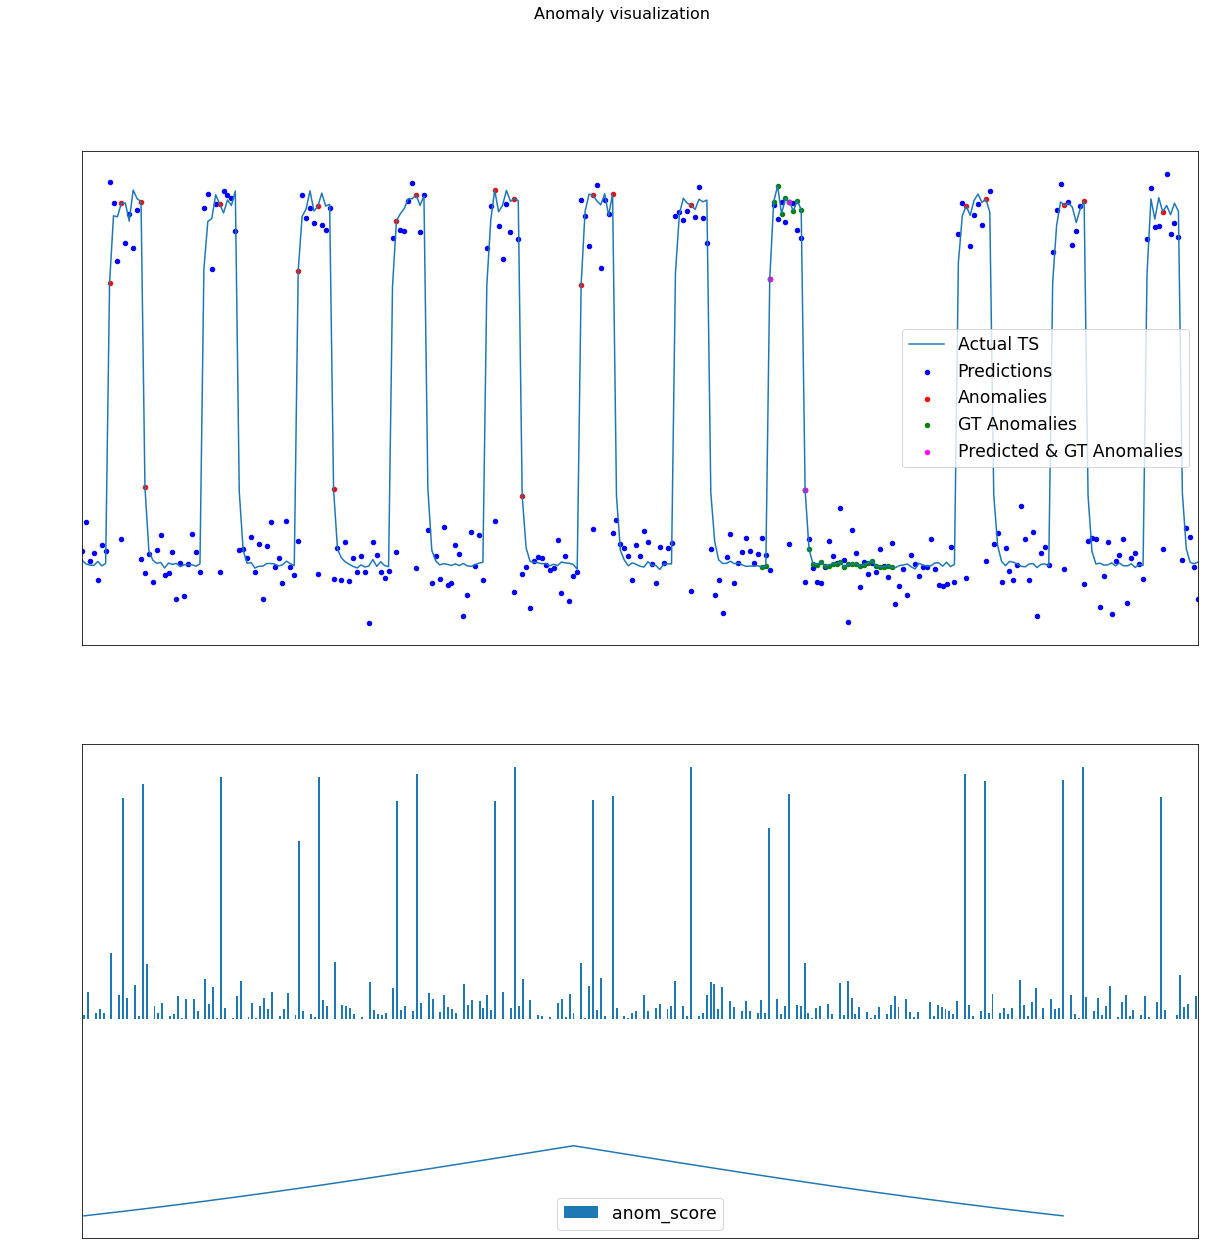

Customized score:  0.5329892332338859
0.039154058065167516


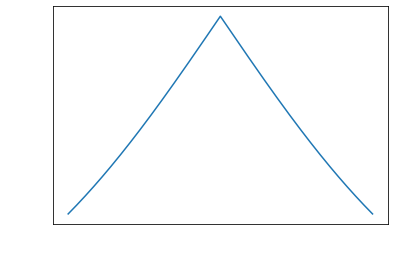

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 12, 64)            16896     
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                33024     
_________________________________________________________________


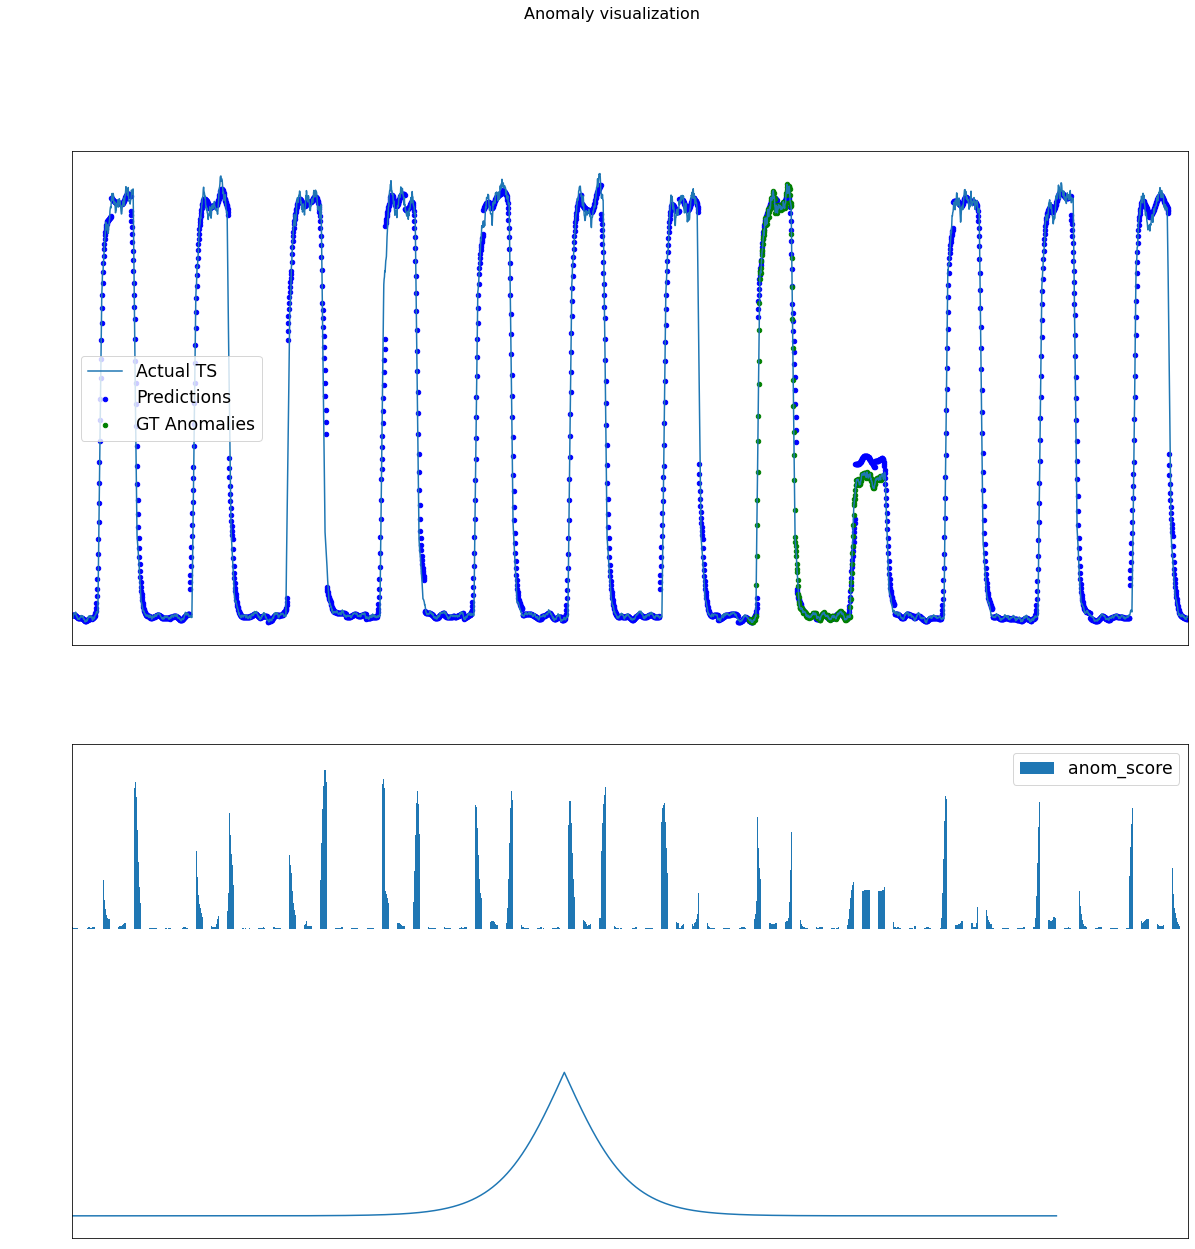

dropout_2 (Dropout)          (None, 64)                0         Customized score: 
_________________________________________________________________ 
dense_1 (Dense)              (None, 1)                 65        0.3333333333333333

Total params: 49,985
Trainable params: 49,985
Non-trainable params: 0
_________________________________________________________________
0.0
Epoch 1/50


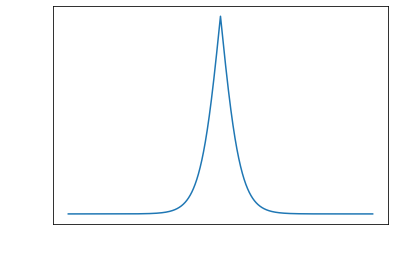

<ipython-input-19-2e85185fa41f>:16: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  return results_df.loc[test_df.index & results_df.index]
<ipython-input-18-a71f714408fd>:16: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  return results_df.loc[test_df.index & results_df.index]


0.058865129144131445
1/1 [==============================] - ETA: 0s - loss: 0.5163 - 4s 4s/step - loss: 0.5163 - val_loss: 0.1177
Epoch 2/50
1/1 [==============================] - ETA: 0s - loss: 0.4963 - 0s 66ms/step - loss: 0.4963 - val_loss: 0.1156
Epoch 3/50
1/1 [==============================] - ETA: 0s - loss: 0.4801 - 0s 71ms/step - loss: 0.4801 - val_loss: 0.1137
Epoch 4/50
1/1 [==============================] - ETA: 0s - loss: 0.4630 - 0s 68ms/step - loss: 0.4630 - val_loss: 0.1118
Epoch 5/50
1/1 [==============================] - ETA: 0s - loss: 0.4456 - 0s 85ms/step - loss: 0.4456 - val_loss: 0.1100
Epoch 6/50
1/1 [==============================] - ETA: 0s - loss: 0.4317

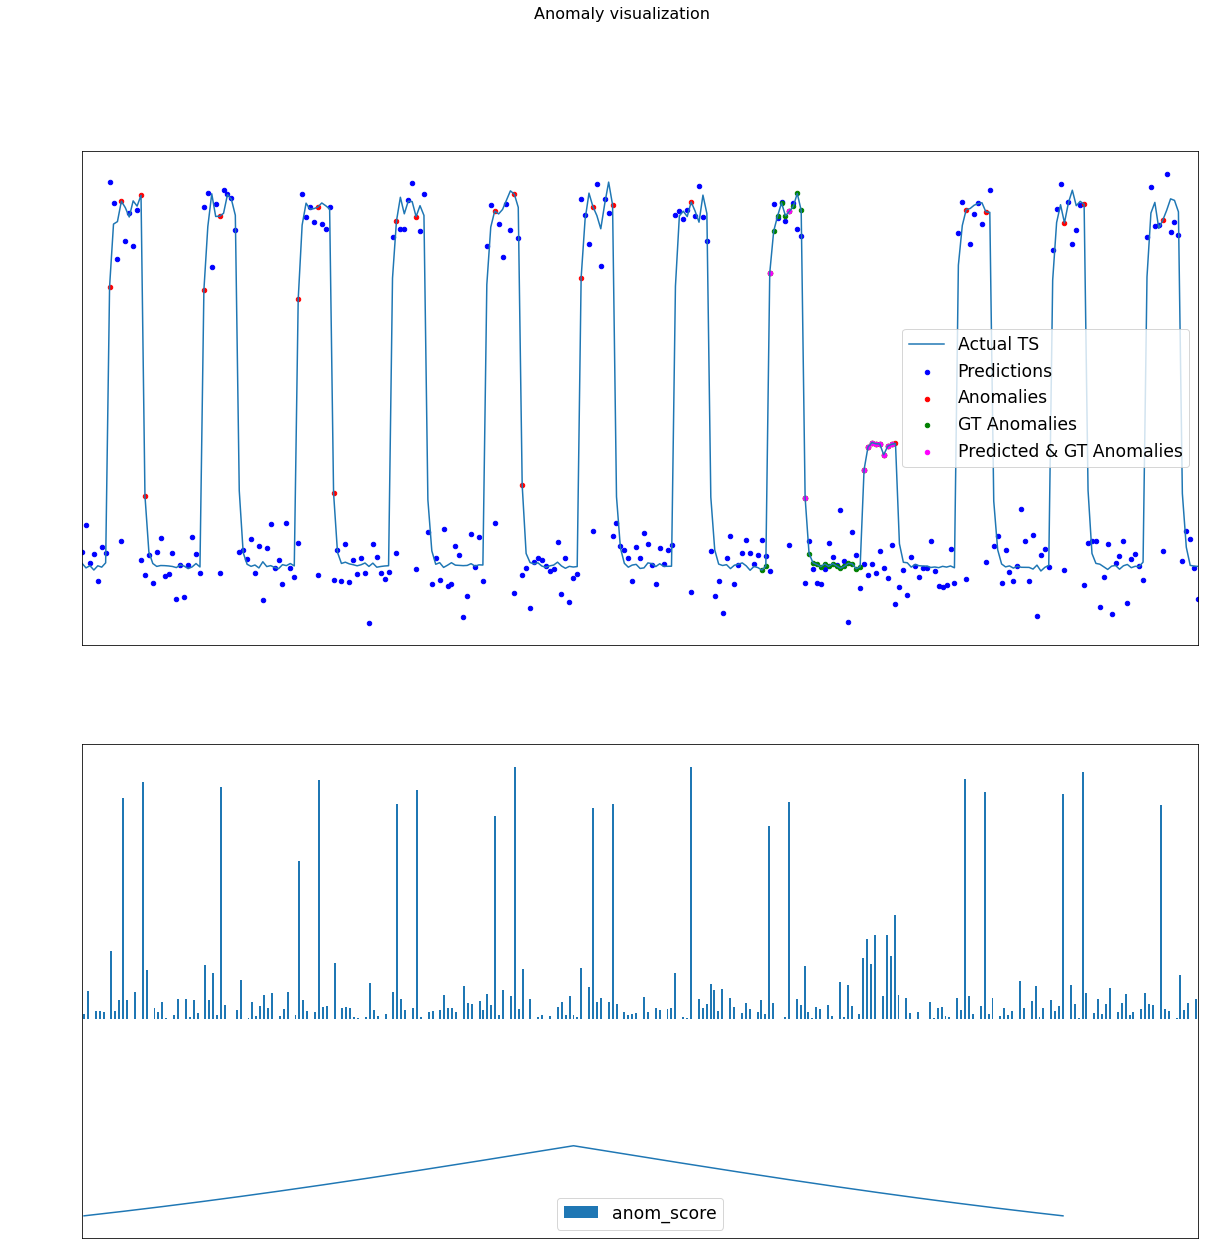

Customized score:  0.5368179049960607
1/1 [==============================] - 0s 77ms/step - loss: 0.4120 - val_loss: 0.1071
Epoch 8/50
0.058865129144131445
1/1 [==============================] - ETA: 0s - loss: 0.4004 - 0s 72ms/step - loss: 0.4004 - val_loss: 0.1062
Epoch 9/50
1/1 [==============================] - ETA: 0s - loss: 0.3798

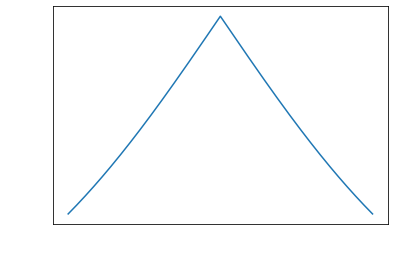

1/1 [==============================] - 0s 72ms/step - loss: 0.3798 - val_loss: 0.1059
Epoch 10/50
1/1 [==============================] - ETA: 0s - loss: 0.3641 - 0s 70ms/step - loss: 0.3641 - val_loss: 0.1064
Epoch 11/50
1/1 [==============================] - ETA: 0s - loss: 0.3511 - 0s 74ms/step - loss: 0.3511 - val_loss: 0.1079
Epoch 12/50
1/1 [==============================] - ETA: 0s - loss: 0.3332 - 0s 67ms/step - loss: 0.3332 - val_loss: 0.1108
Epoch 13/50
1/1 [==============================] - ETA: 0s - loss: 0.3257 - 0s 90ms/step - loss: 0.3257 - val_loss: 0.1157
Epoch 14/50
1/1 [==============================] - ETA: 0s - loss: 0.3188 - 0s 101ms/step - loss: 0.3188 - val_loss: 

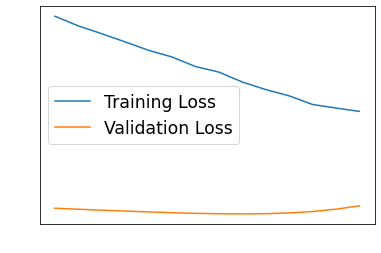

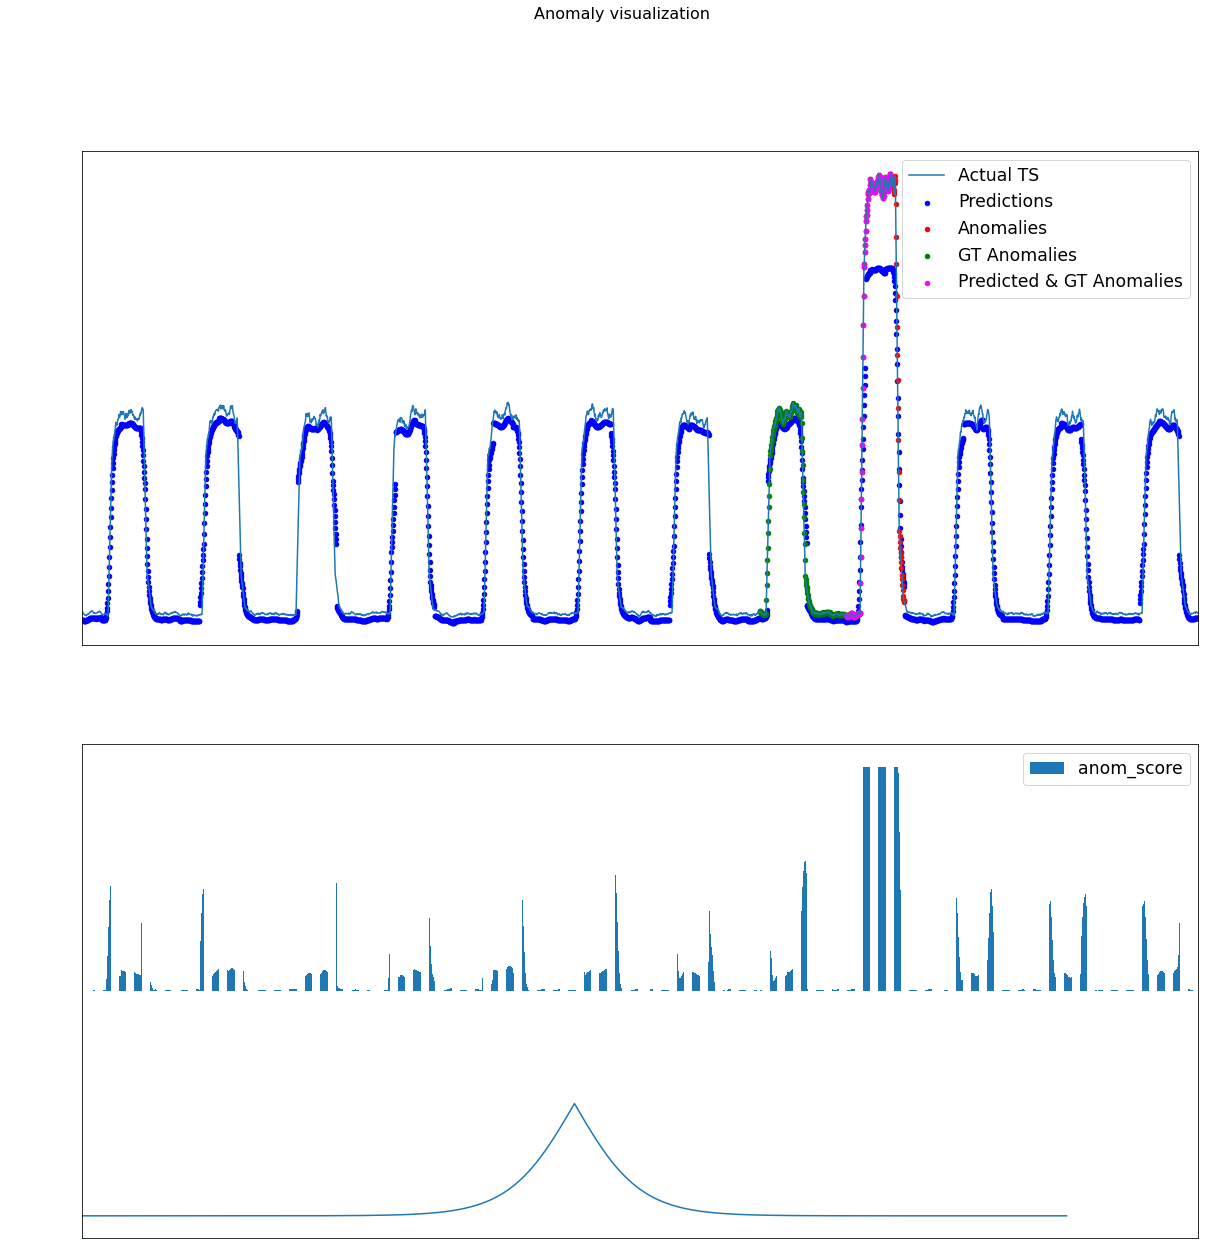

Customized score:  0.5556805391278267
2.304370407569737e-14


<ipython-input-20-660c86c91a15>:16: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  return results_df.loc[test_df.index & results_df.index]


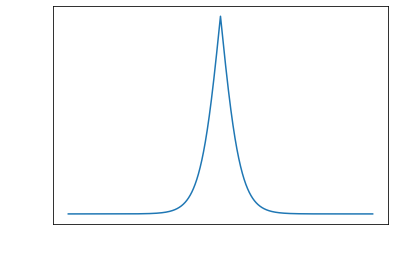

0.011842558816325744


<ipython-input-19-2e85185fa41f>:16: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  return results_df.loc[test_df.index & results_df.index]


1/1 [==============================] - ETA: 0s - loss: 0.5027 - 3s 3s/step - loss: 0.5027 - val_loss: 0.1221
Epoch 2/50
1/1 [==============================] - ETA: 0s - loss: 0.4830 - 0s 91ms/step - loss: 0.4830 - val_loss: 0.1205
Epoch 3/50
1/1 [==============================] - ETA: 0s - loss: 0.4685 - 0s 66ms/step - loss: 0.4685 - val_loss: 0.1191
Epoch 4/50
1/1 [==============================] - 0s 82ms/step - loss: 0.4559 - val_loss: 0.1178
Epoch 5/50
1/1 [==============================] - ETA: 0s - loss: 0.4346 - 0s 61ms/step - loss: 0.4346 - val_loss: 0.1167
Epoch 6/50
1/1 [==============================] - ETA: 0s - loss: 0.4176

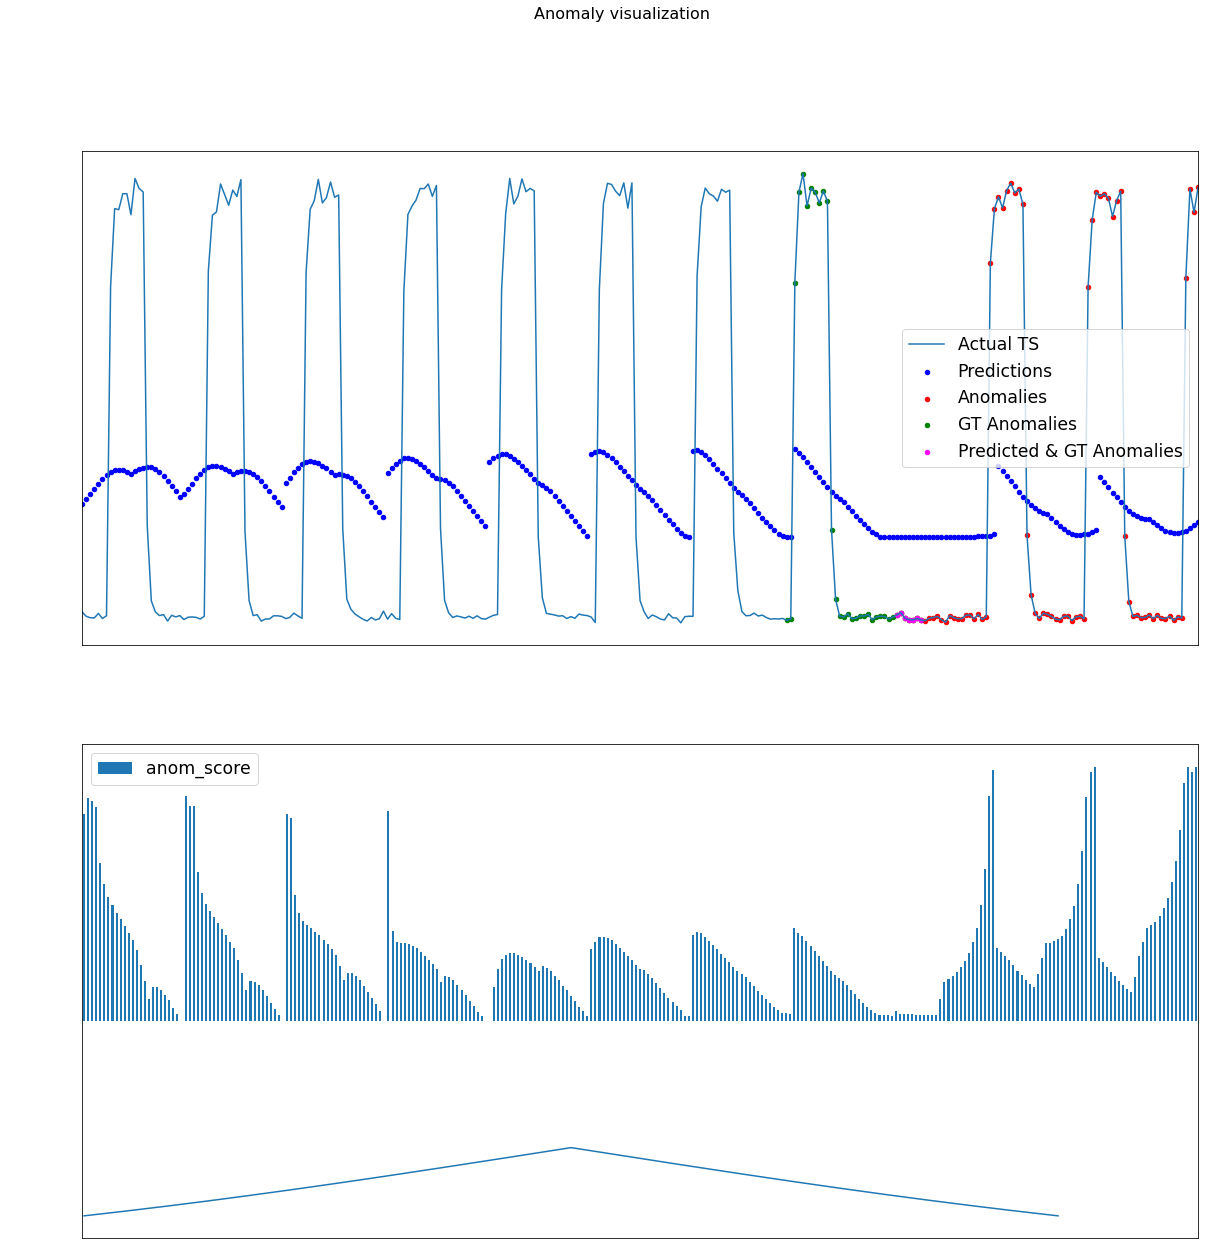

Customized score:  0.37173002962269036
0.011842558816325744
1/1 [==============================] - 0s 66ms/step - loss: 0.4176 - val_loss: 0.1157
Epoch 7/50
1/1 [==============================] - ETA: 0s - loss: 0.4031 - 0s 69ms/step - loss: 0.4031 - val_loss: 0.1149
Epoch 8/50
1/1 [==============================] - ETA: 0s - loss: 0.3947

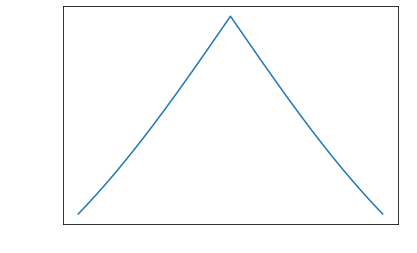

1/1 [==============================] - 0s 85ms/step - loss: 0.3947 - val_loss: 0.1144
Epoch 9/50
1/1 [==============================] - ETA: 0s - loss: 0.3752 - 0s 60ms/step - loss: 0.3752 - val_loss: 0.1143
Epoch 10/50
1/1 [==============================] - ETA: 0s - loss: 0.3681 - 0s 61ms/step - loss: 0.3681 - val_loss: 0.1146
Epoch 11/50
1/1 [==============================] - ETA: 0s - loss: 0.3517 - 0s 65ms/step - loss: 0.3517 - val_loss: 0.1156
Epoch 12/50
1/1 [==============================] - ETA: 0s - loss: 0.3386 - 0s 63ms/step - loss: 0.3386 - val_loss: 0.1175
Epoch 13/50
1/1 [==============================] - ETA: 0s - loss: 0.3248 - 0s 60ms/step - lo

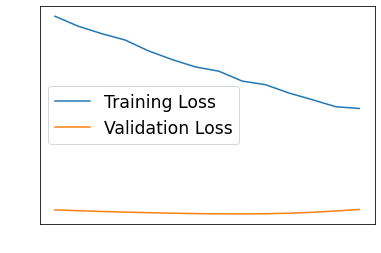

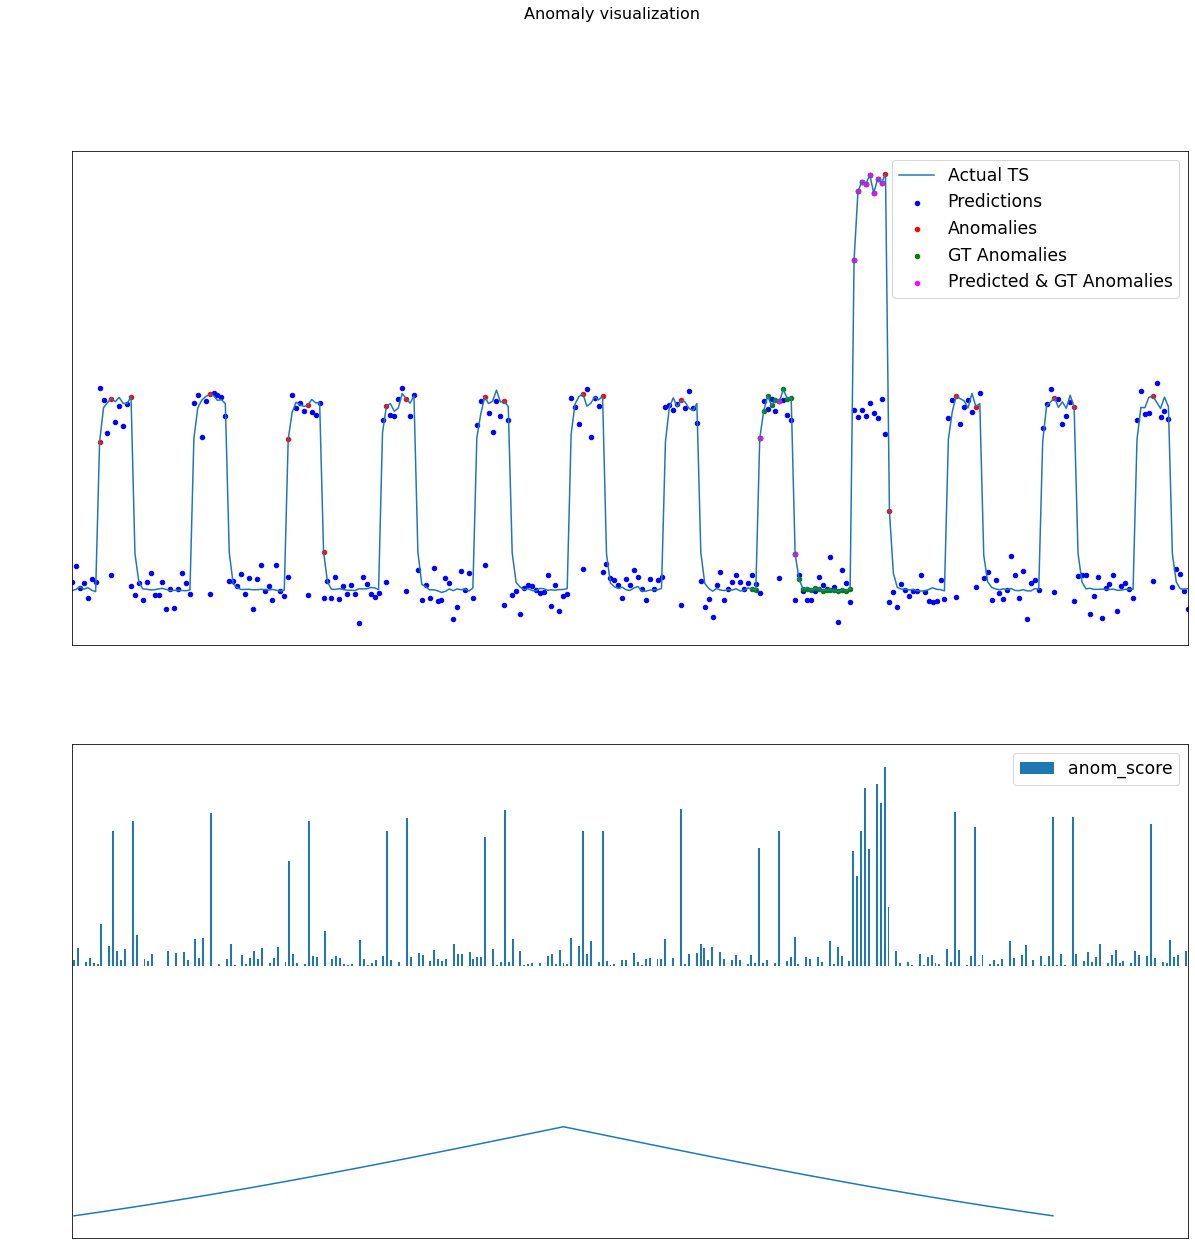

Customized score:  0.540683422945733
0.058865129144131445


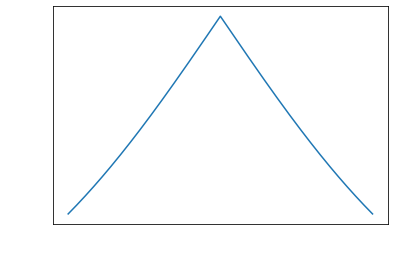

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 12, 64)            16896     
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 49,985
Trainable params: 49,985
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50


<ipython-input-20-660c86c91a15>:16: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  return results_df.loc[test_df.index & results_df.index]


0.0
0.0


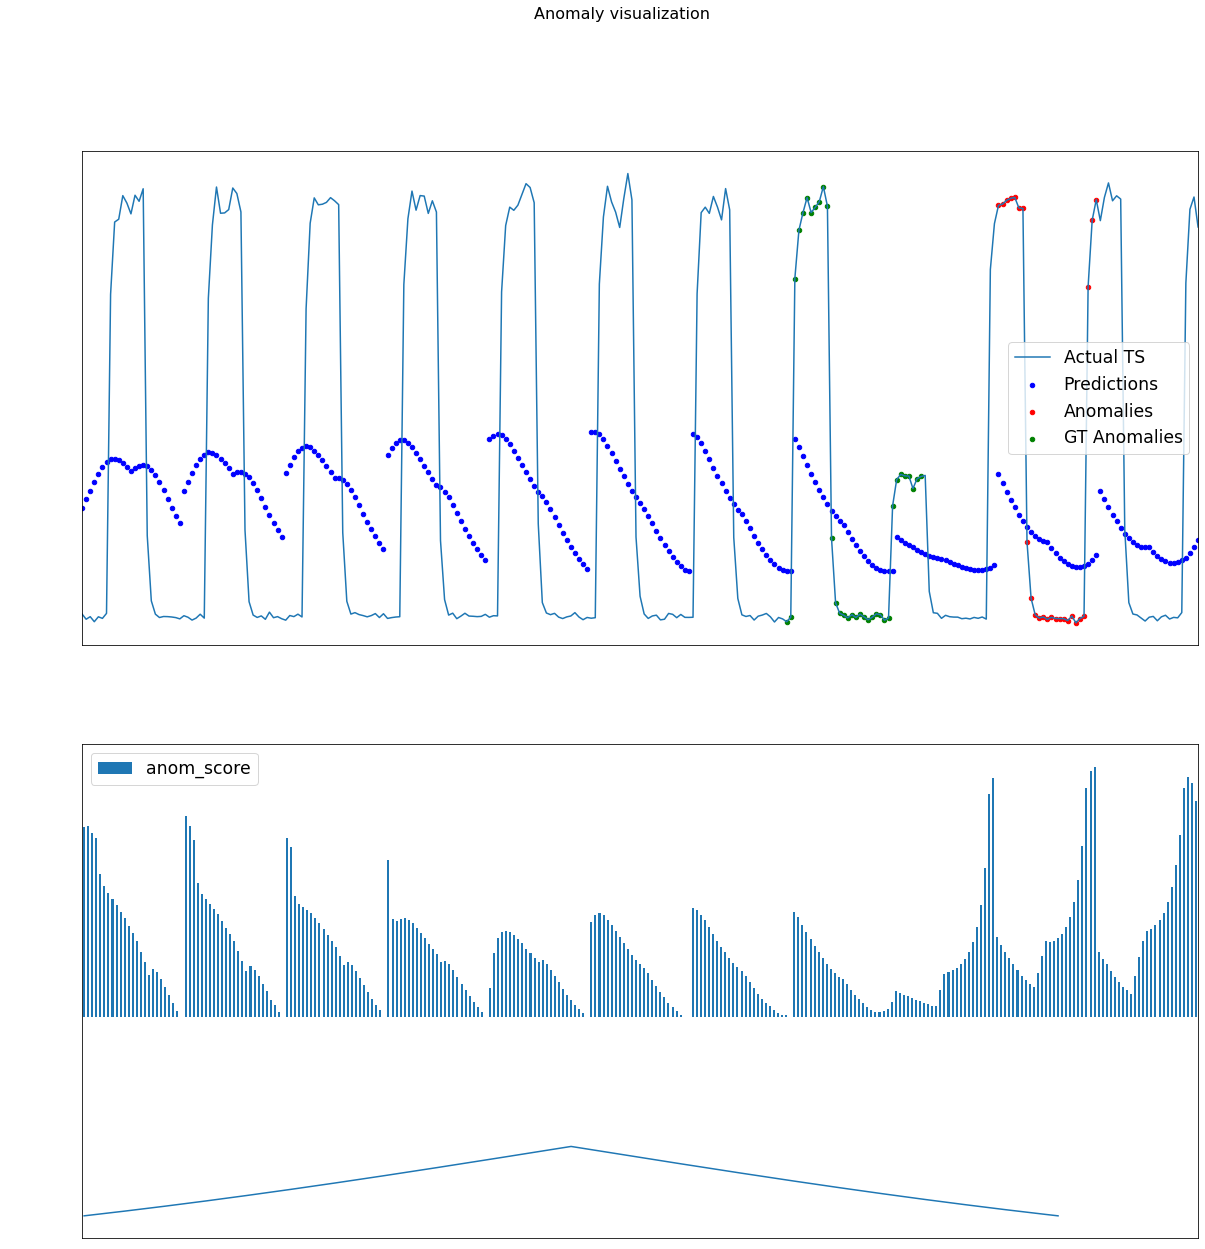

Customized score:  0.2958570358844573
0.0
1/1 [==============================] - ETA: 0s - loss: 0.1179

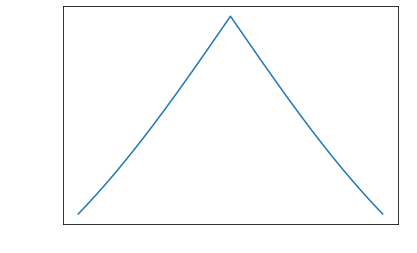

1/1 [==============================] - 3s 3s/step - loss: 0.1179 - val_loss: 0.0267
Epoch 2/50
1/1 [==============================] - ETA: 0s - loss: 0.1118 - 0s 67ms/step - loss: 0.1118 - val_loss: 0.0260
Epoch 3/50
1/1 [==============================] - ETA: 0s - loss: 0.1057 - 0s 87ms/step - loss: 0.1057 - val_loss: 0.0254
Epoch 4/50
1/1 [==============================] - ETA: 0s - loss: 0.1017 - 0s 63ms/step - loss: 0.1017 - val_loss: 0.0248
Epoch 5/50
1/1 [==============================] - ETA: 0s - loss: 0.0966 - 0s 60ms/step - loss: 0.0966 - val_loss: 0.0243
Epoch 6/50
1/1 [==============================] - ETA: 0s - loss: 0.0923 - 0s 80ms/step - loss: 0.

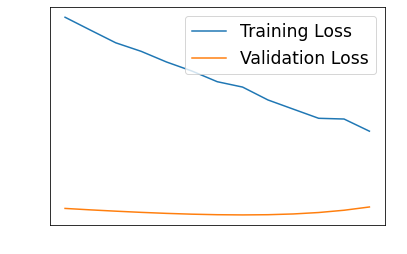

<ipython-input-20-660c86c91a15>:16: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  return results_df.loc[test_df.index & results_df.index]


1.9877715854977227


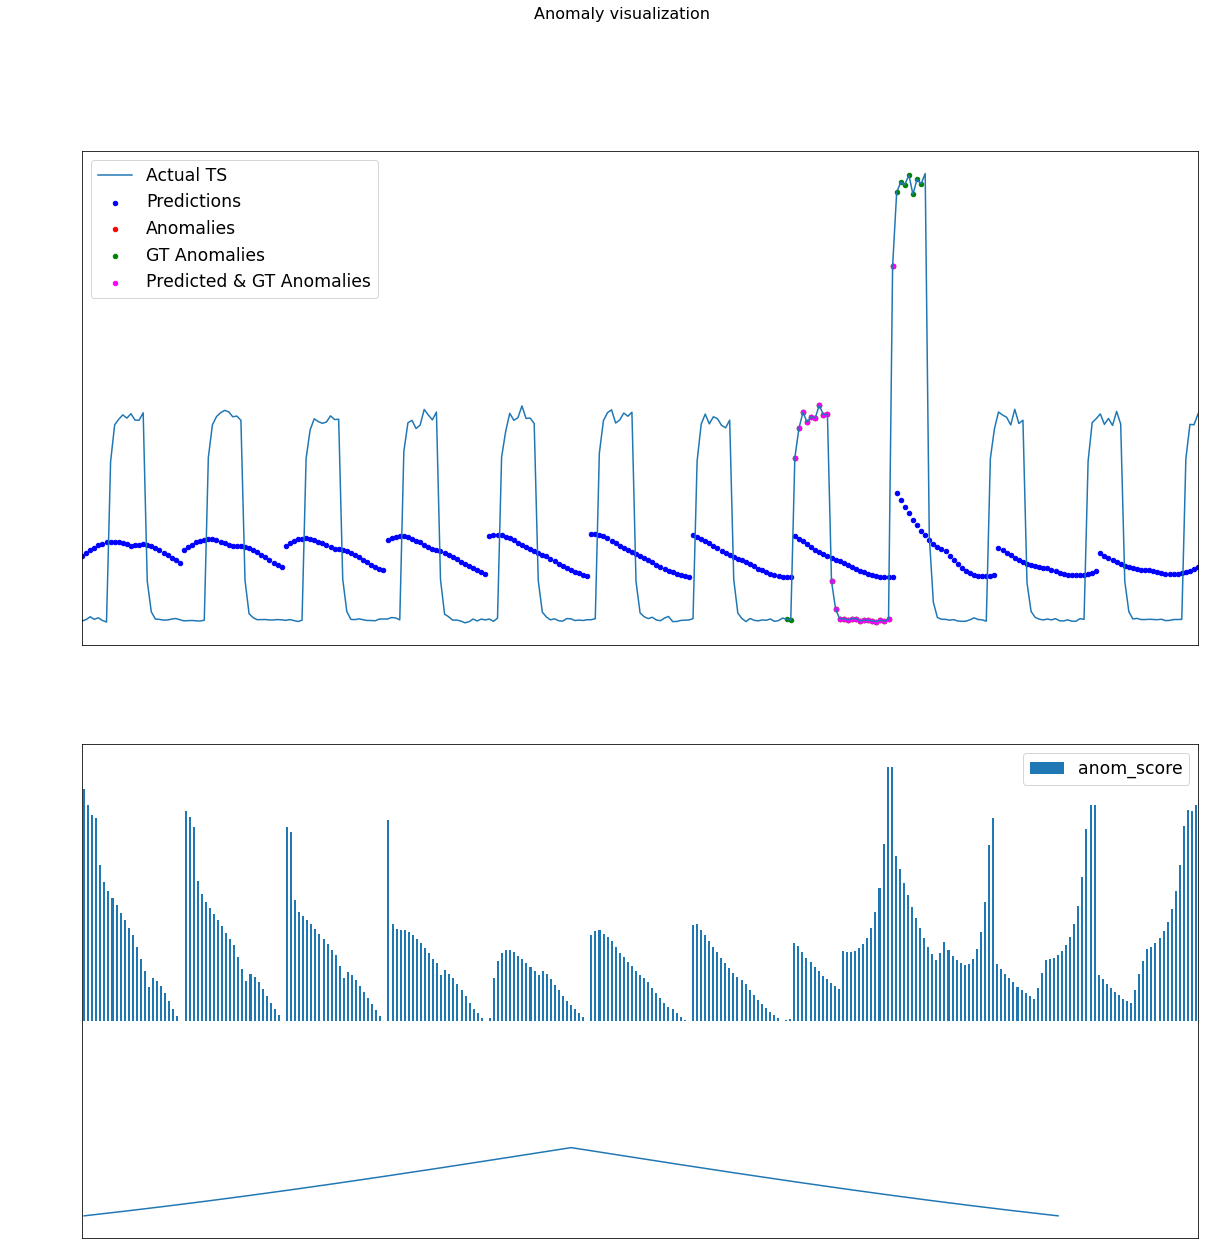

Customized score:  1.0
1.9877715854977227


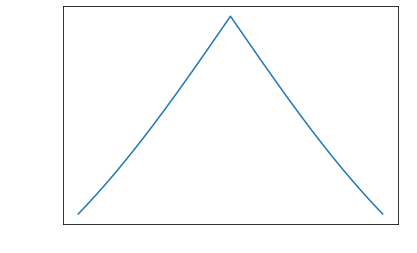

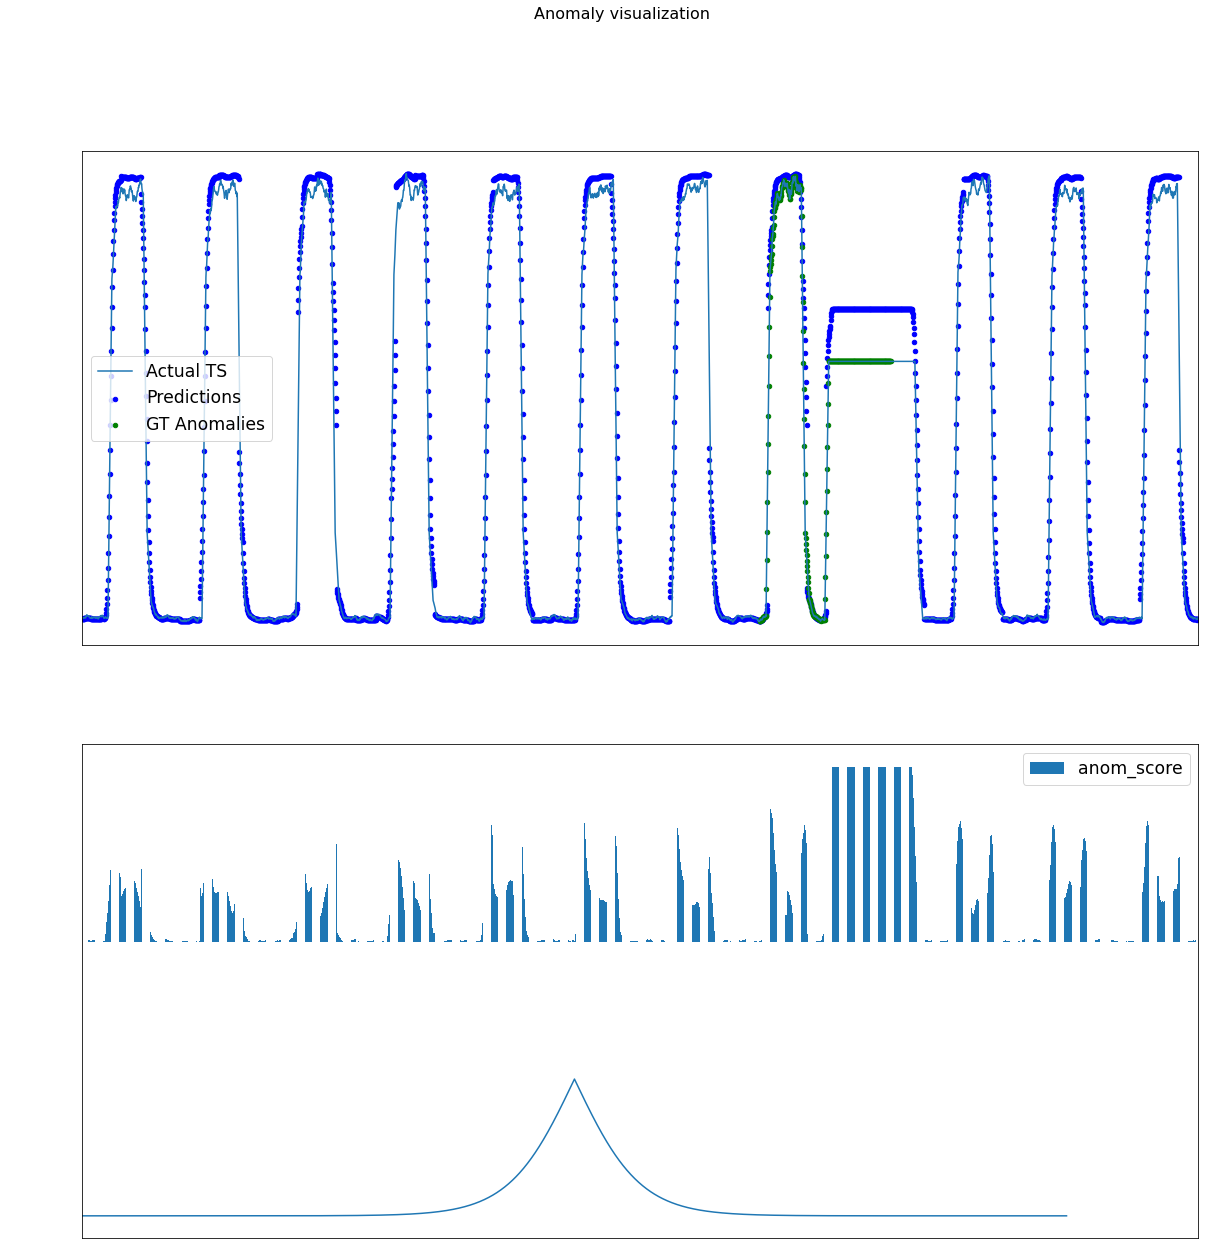

Customized score:  0.3333333333333333
0.0


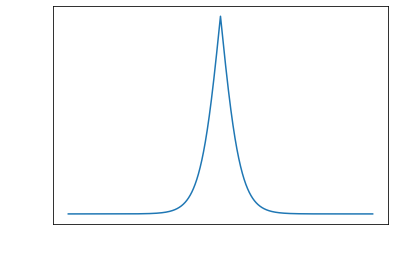

<ipython-input-19-2e85185fa41f>:16: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  return results_df.loc[test_df.index & results_df.index]


1.2181235674124362


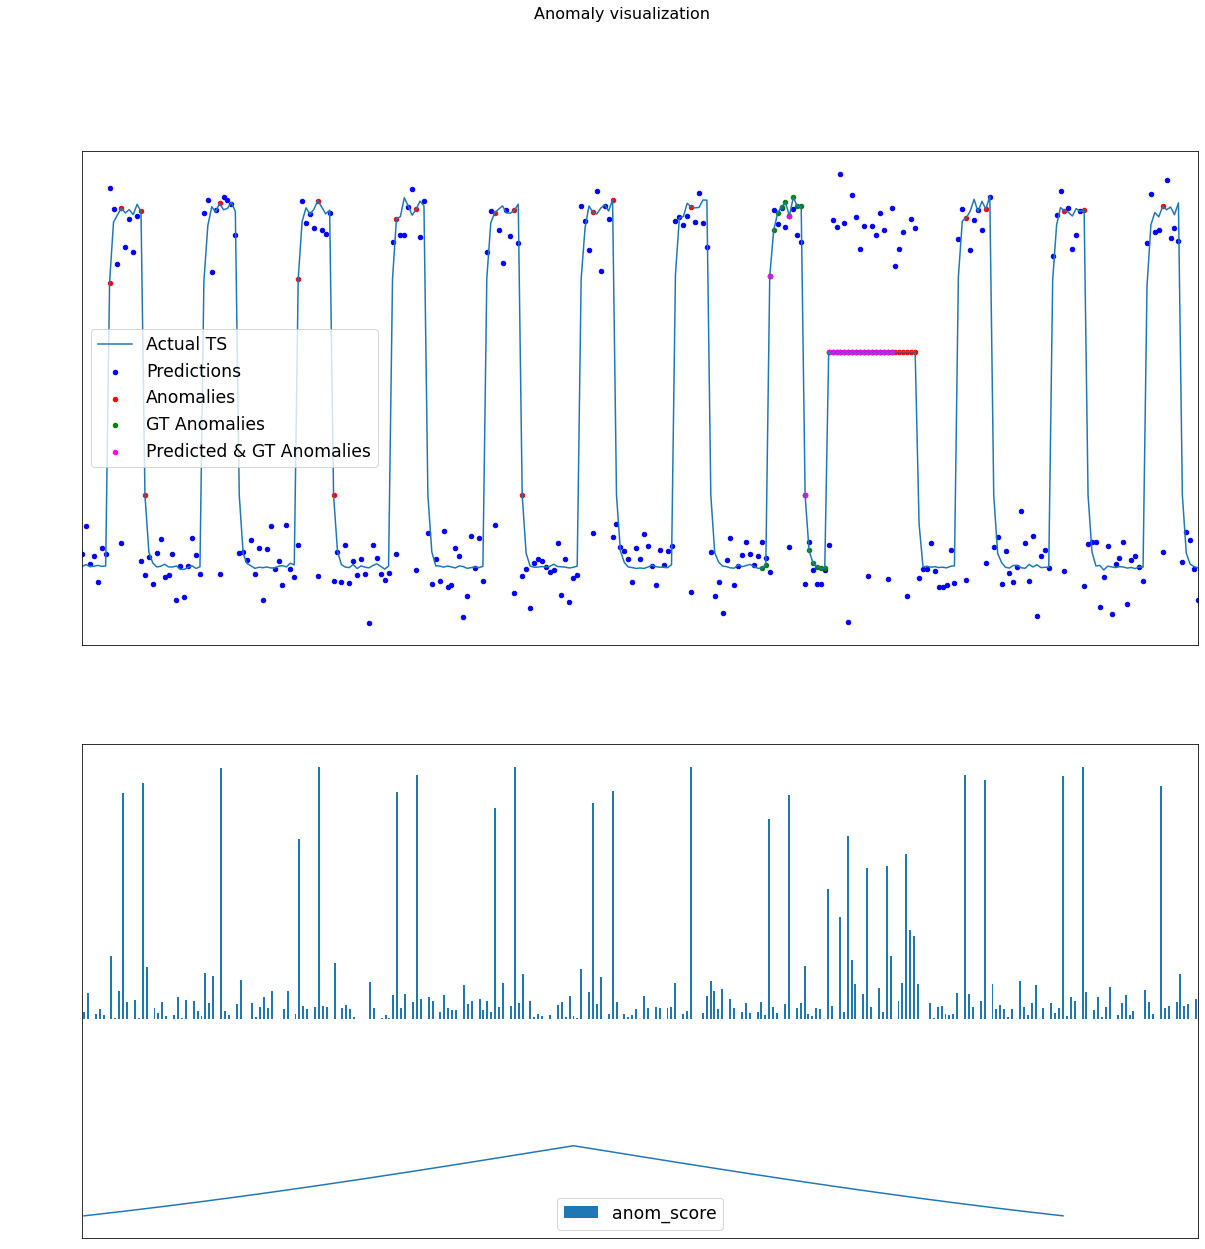

Customized score:  0.9642801537402589
1.2181235674124362


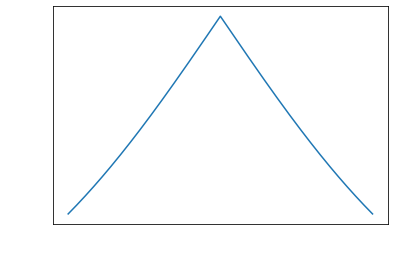

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 12, 64)            16896     
_________________________________________________________________
lstm_3 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 49,985
Trainable params: 49,985
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50


Process ForkProcess-14:
Process ForkProcess-20:
Process ForkProcess-16:


In [ ]:
from typing import Tuple
import concurrent

eval_dict: dict = {}

X_LABEL = "timestamp"
data_dir = "data/archive/"
file_dir = "artificialWithAnomaly"

with open("data/archive/combined_windows.json") as f:
    ground_true_anomalies = json.load(f)

executor = concurrent.futures.ProcessPoolExecutor()


def task_executor(filename: str, original_df: pd.DataFrame, ground_true_anomalies: dict, eval_func):
    file_eval_dict = {}

    true_anomalies_ranges = ground_true_anomalies["/".join(file_path.split("/")[-2:])]
    ground_true_anomalies_df = pd.DataFrame()
    for anom_range in true_anomalies_ranges:
        ground_true_anomalies_df = ground_true_anomalies_df.append(
            original_df.loc[anom_range[0]:anom_range[1]])
    original_df[kad_utils.GROUND_TRUTH_COLUMN] = [idx in ground_true_anomalies_df.index for idx in
                                                  original_df.index.tolist()]

    # SARIMA
    preprocessed_df = original_df.groupby(pd.Grouper(freq="h")).apply(downsampling_func)
    scaler = MinMaxScaler(feature_range=(0, 1))
    preprocessed_df["value"] = scaler.fit_transform(preprocessed_df.values)

    file_eval_dict[SARIMA_KEY] = eval_func(evaluate_sarima(preprocessed_df))

    # AUTOENCODER
    preprocessed_df = original_df.copy()
    preprocessed_df["value"] = preprocessed_df["value"].rolling("h").sum()
    scaler = MinMaxScaler(feature_range=(0, 1))
    preprocessed_df["value"] = scaler.fit_transform(preprocessed_df.values)

    file_eval_dict[AUTOENCODER_KEY] = eval_func(evaluate_autoencoder(preprocessed_df))

    # HMM
    preprocessed_df = original_df.groupby(pd.Grouper(freq="h")).apply(downsampling_func)
    scaler = MinMaxScaler(feature_range=(0, 1))
    preprocessed_df["value"] = scaler.fit_transform(preprocessed_df.values)

    file_eval_dict[HMM_KEY] = eval_func(evaluate_hmm(preprocessed_df))

    # LSTM
    preprocessed_df = original_df.groupby(pd.Grouper(freq="h")).apply(downsampling_func)
    scaler = MinMaxScaler(feature_range=(0, 1))
    preprocessed_df["value"] = scaler.fit_transform(preprocessed_df.values)

    file_eval_dict[LSTM_KEY] = eval_func(evaluate_lstm(preprocessed_df))

    return filename, file_eval_dict


files_to_eval = ["art_daily_flatmiddle.csv",
                 "art_daily_jumpsdown.csv",
                 "art_daily_nojump.csv",
                 "art_daily_jumpsup.csv"]

futures_table = list()

for (dirpath, dirnames, filenames) in os.walk(data_dir):
    for filename in filenames:
        if filename in files_to_eval:
            file_path = os.path.join(dirpath, filename)
            original_df = pd.read_csv(file_path, parse_dates=True, index_col="timestamp")
            print("after reading csv")
            futures_table.append(
                executor.submit(task_executor, filename, original_df, ground_true_anomalies, perform_customized_evaluation))

for future in futures_table:
    result: Tuple[str, dict] = future.result()
    eval_dict[result[0]] = result[1]

In [ ]:
eval_json = "eval.json"

with open(eval_json, "w") as fp:
    json.dump(eval_dict, fp)
